In [288]:
# @title
from IPython.display import Image, display

# Display the image with a specified width and height
display(Image(url="https://img-cdn.thepublive.com/entrackr/media/post_attachments/wp-content/uploads/2018/06/Ola_Revenue_image.gif", width=1500, height=700))


# *OLA ENSEMBLE LEARNING*<br>
##Analyzed by Shama Bansal

## *Problem Statement*

Ola, a leading ride-hailing company, faces a significant challenge in retaining its drivers. High attrition rates among drivers lead to increased recruitment costs, lowered driver morale, and operational inefficiencies. Since drivers can easily switch to competitors, such as Uber, depending on pay rates or incentives, reducing driver churn has become a critical business concern.

The cost of acquiring new drivers is significantly higher than retaining existing ones, making it essential to identify patterns and factors that influence driver attrition. By predicting which drivers are likely to leave, Ola can implement targeted interventions to improve retention, enhance driver satisfaction, and ultimately reduce costs.

This project aims to build a predictive model to identify drivers at risk of leaving the company. Using demographic, performance, and tenure-related data, the model will help Ola take preemptive measures to reduce attrition and improve driver engagement.

Key objectives include:
1. Identifying the key factors contributing to driver attrition.
2. Predicting the likelihood of a driver leaving based on historical data.
3. Providing actionable insights and recommendations to help Ola retain its drivers.

The model will utilize advanced machine learning techniques, including ensemble learning methods like Bagging and Boosting, to ensure high prediction accuracy. Additionally, it will address class imbalance issues inherent in the dataset, as only a subset of drivers are likely to leave, while the majority will remain.


# *Importing Packages*

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import plotly.graph_objects as go


from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,accuracy_score, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier


import warnings
warnings.filterwarnings('ignore')

In [290]:
# @title *Downloading and reading Dataset*
!gdown 1cm0gdTtymY8vwzru7YtSWJrfDP7A-bnf

Downloading...
From: https://drive.google.com/uc?id=1cm0gdTtymY8vwzru7YtSWJrfDP7A-bnf
To: /content/ola_driver_scaler.csv
100% 1.13M/1.13M [00:00<00:00, 12.3MB/s]


In [291]:
df=pd.read_csv('ola_driver_scaler.csv')
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [292]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            19104 non-null  int64  
 1   MMM-YY                19104 non-null  object 
 2   Driver_ID             19104 non-null  int64  
 3   Age                   19043 non-null  float64
 4   Gender                19052 non-null  float64
 5   City                  19104 non-null  object 
 6   Education_Level       19104 non-null  int64  
 7   Income                19104 non-null  int64  
 8   Dateofjoining         19104 non-null  object 
 9   LastWorkingDate       1616 non-null   object 
 10  Joining Designation   19104 non-null  int64  
 11  Grade                 19104 non-null  int64  
 12  Total Business Value  19104 non-null  int64  
 13  Quarterly Rating      19104 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 2.0+ MB



## *Dataset Overview*:
- **Total entries**: 19,104 rows, indicating a substantial amount of data on driver performance and demographics over time.
- **Total columns**: 14 columns, capturing various details like driver demographics, income, employment details, and performance ratings.

### **Columns Breakdown**:
1. **`Unnamed: 0`**:
   - This seems like an unnecessary index column, likely generated during file export. It can be safely dropped.
   
2. **`MMM-YY`** (Reporting Date):
   - Data type: `object` (string).
   - Should be converted to a proper `datetime` format for easier analysis and aggregation over time.

3. **`Driver_ID`**:
   - Unique identifier for drivers.
   - Likely needs to be used for grouping and aggregation, especially for performance tracking over time.

4. **`Age`**:
   - 19,043 non-null values, meaning 61 entries have missing age values.
   - Since this is a crucial demographic feature, missing values need to be handled carefully, potentially through imputation.

5. **`Gender`**:
   - 19,052 non-null values, with 52 missing values.
   - Gender is encoded as `0` for male and `1` for female, but the missing values need to be addressed.
   
6. **`City`**:
   - Categorical feature that identifies the city where drivers operate.
   - No missing values, which is good. However, this column might require encoding for modeling.

7. **`Education_Level`**:
   - Numeric encoding for education: `0` (10+), `1` (12+), `2` (Graduate).
   - No missing values. This feature might influence driver attrition or performance.

8. **`Income`**:
   - Monthly income of the drivers.
   - No missing values, so this can be directly used in the analysis.

9. **`Dateofjoining`**:
   - Date when the driver joined the company.
   - This column is in `object` format and should be converted to a `datetime` format to derive features such as tenure.

10. **`LastWorkingDate`**:
    - Only 1,616 non-null values, meaning most drivers have not left the company yet (likely active drivers).
    - This is a key feature for the target variable (attrition), indicating which drivers have left.

11. **`Joining Designation`**:
    - Coded as integers, representing the designation drivers started with.
    - No missing values.

12. **`Grade`**:
    - Represents the grade of drivers at the time of reporting.
    - No missing values, making this feature useful for performance analysis.

13. **`Total Business Value`**:
    - Represents the total business value drivers brought in a month.
    - No missing values, but the presence of negative values (indicating cancellations or refunds) should be explored further.
  
14. **`Quarterly Rating`**:
    - Ratings of drivers, likely from 1 to 5, with higher ratings being better.
    - No missing values, useful for performance-related analysis.

### **Data Quality Issues**:
1. **Missing values**:
   - `Age`: 61 missing values.
   - `Gender`: 52 missing values.
   - `LastWorkingDate`: 16,488 missing values (these drivers are still active).

2. **Data type conversion**:
   - `MMM-YY` and `Dateofjoining` should be converted to `datetime`.
   - This allows for the creation of derived features such as tenure (time spent with the company).

3. **Duplicate Entries**:
   - Check for duplicate `Driver_ID` entries, especially across different months.
   - Aggregation or deduplication may be needed to analyze each driver uniquely.

4. **Negative Business Value**:
   - Investigate the negative values in the `Total Business Value` column, as they might represent cancellations or deductions.


In [293]:
df.nunique()

,0
Unnamed: 0,19104
MMM-YY,24
Driver_ID,2381
Age,36
Gender,2
City,29
Education_Level,3
Income,2383
Dateofjoining,869
LastWorkingDate,493


In [294]:
# @title *Checking Duplicates*
df.duplicated().sum()

0

'Unnamed: 0' is  serial no feature so no use of this, so dropping this feature.

In [295]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [296]:
# @title *Data Preprocessing*
df['Dateofjoining']=pd.to_datetime(df['Dateofjoining'])
df['MMM-YY']=pd.to_datetime(df['MMM-YY'])
df['LastWorkingDate']=pd.to_datetime(df['LastWorkingDate'],errors='coerce')
df.rename(columns={'MMM-YY':'Reporting_month'},inplace=True)

Changing the datatypes of columns having object dataypes to datetime and category

In [297]:
# @title *Checking Missing Values*
df.isna().sum()/len(df)*100

,0
Reporting_month,0.000000
Driver_ID,0.000000
Age,0.319305
Gender,0.272194
City,0.000000
Education_Level,0.000000
Income,0.000000
Dateofjoining,0.000000
LastWorkingDate,91.541039
Joining Designation,0.000000


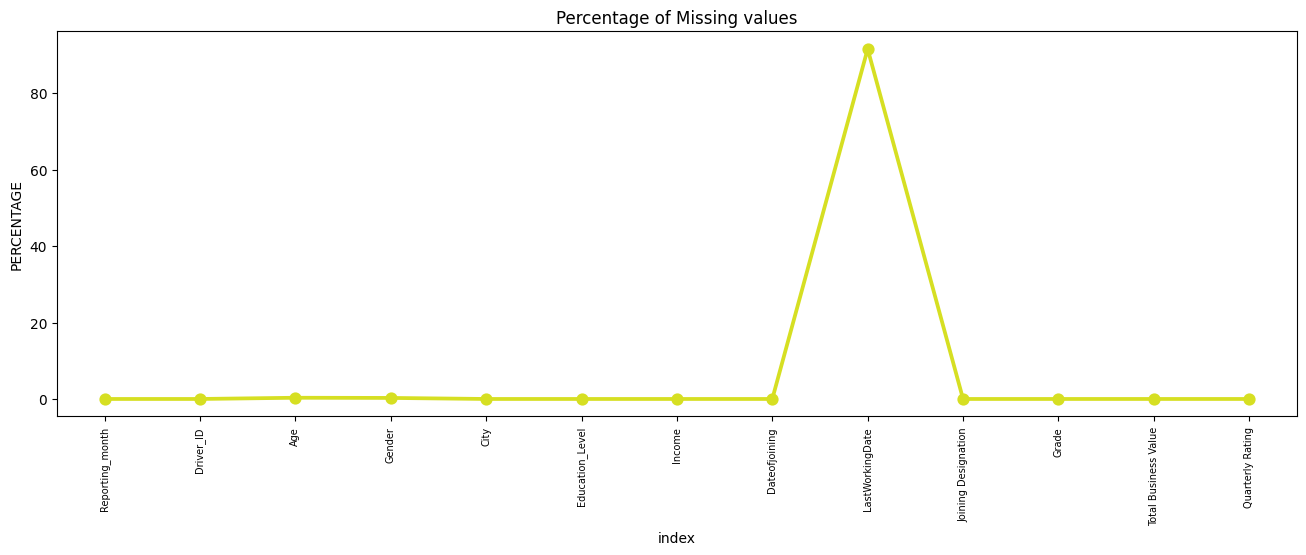

In [298]:
missing = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index',y=0,data=missing,color='#D6DF22')
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

# *KNN Imputation*

In [299]:
def highlight_row(row, highlight_index):
    return ['background-color: red' if row.name in highlight_index else '' for _ in range(len(dff.columns))]

# Wrapper function that applies the highlight with a dynamic index
def apply_highlight(dff, highlight_index):
    return dff.style.apply(lambda row: highlight_row(row, highlight_index), axis=1)

In [300]:
# using numerical columns for knn computation
num_vars = df.select_dtypes(np.number)

num_vars.columns
imputer = KNNImputer()
imputer.fit(num_vars)
data_new = imputer.transform(num_vars)
data_new = pd.DataFrame(data_new)
data_new.columns = num_vars.columns

data_new.isnull().sum()

,0
Driver_ID,0
Age,0
Gender,0
Education_Level,0
Income,0
Joining Designation,0
Grade,0
Total Business Value,0
Quarterly Rating,0


In [301]:
dff=data_new[data_new['Driver_ID']==541]

highlighted_df = apply_highlight(dff, [3618,3627])
highlighted_df

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
3614,541.000000,26.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,0.000000,1.000000
3615,541.000000,26.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,272170.000000,1.000000
3616,541.000000,26.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,385400.000000,1.000000
3617,541.000000,26.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,50000.000000,1.000000
3618,541.000000,34.400000,0.000000,2.000000,71812.000000,1.000000,2.000000,104380.000000,1.000000
3619,541.000000,26.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,0.000000,1.000000
3620,541.000000,26.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,210210.000000,2.000000
3621,541.000000,26.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,41000.000000,2.000000
3622,541.000000,27.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,601820.000000,2.000000
3623,541.000000,27.000000,0.000000,2.000000,71812.000000,1.000000,2.000000,200000.000000,2.000000


We can see knn computation is not giving correct values as for Driver Id 541 whose age is 26, its imputing 34.40 and Gender is imputed as 0.80 while we have values as 0 and 1 only for gender columns.<br><br>
Lets try imputation with scaled data

In [302]:
# Scaling data for imputation
stndscaler=StandardScaler()
stndscaler.fit(num_vars)
data_new_scaled=stndscaler.transform(num_vars)
data_new_scaled=pd.DataFrame(data_new_scaled,columns=num_vars.columns)
data_new_scaled.head()

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,-1.744935,-1.065629,-0.848779,1.222688,-0.267358,-0.825051,-1.220348,1.603674,-0.008812
1,-1.744935,-1.065629,-0.848779,1.222688,-0.267358,-0.825051,-1.220348,-1.096482,-0.008812
2,-1.744935,-1.065629,-0.848779,1.222688,-0.267358,-0.825051,-1.220348,-0.506666,-0.008812
3,-1.743702,-0.586223,-0.848779,1.222688,0.044122,0.369747,-0.246150,-0.506666,-0.999102
4,-1.743702,-0.586223,-0.848779,1.222688,0.044122,0.369747,-0.246150,-0.506666,-0.999102


In [303]:
impt=KNNImputer()
data_new_scaled=impt.fit_transform(data_new_scaled)
data_new_scaled=pd.DataFrame(data_new_scaled,columns=num_vars.columns)

dff=data_new_scaled.iloc[3615:3630]


# Specify the row index dynamically (e.g., 3618)
highlighted_df = apply_highlight(dff, [3618,3627])
highlighted_df

,Driver_ID,Age,Gender,Education_Level,Income,Joining Designation,Grade,Total Business Value,Quarterly Rating
3615,-1.078831,-1.385232,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.265441,-0.999102
3616,-1.078831,-1.385232,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.165085,-0.999102
3617,-1.078831,-1.385232,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.462351,-0.999102
3618,-1.078831,-1.321312,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.414153,-0.999102
3619,-1.078831,-1.385232,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.506666,-0.999102
3620,-1.078831,-1.385232,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.320356,-0.008812
3621,-1.078831,-1.385232,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.470327,-0.008812
3622,-1.078831,-1.225431,-0.848779,1.222688,0.199264,-0.825051,-0.246150,0.026729,-0.008812
3623,-1.078831,-1.225431,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.329405,-0.008812
3624,-1.078831,-1.225431,-0.848779,1.222688,0.199264,-0.825051,-0.246150,-0.196149,-0.008812


Even after scaling the same issue is there for age atleast if not for Gender. <br><br>
lets try some more possibilities

In [304]:
# knn imputation using only 2 columns Driver_id and Age
imp=KNNImputer()
columns_for_imputation = df[['Driver_ID', 'Age']]
imputed_data = imp.fit_transform(columns_for_imputation)

# Step 3: Convert the result back to a DataFrame if needed
df_imputed = pd.DataFrame(imputed_data, columns=['Driver_ID', 'Age'])

In [305]:
dff=df_imputed[df_imputed['Driver_ID']==541]
highlighted_df=apply_highlight(dff,[3618])
highlighted_df

,Driver_ID,Age
3614,541.000000,26.000000
3615,541.000000,26.000000
3616,541.000000,26.000000
3617,541.000000,26.000000
3618,541.000000,26.400000
3619,541.000000,26.000000
3620,541.000000,26.000000
3621,541.000000,26.000000
3622,541.000000,27.000000
3623,541.000000,27.000000


Though the difference is not high like before but still I am not using KNN imputation because the missed data can be filled in a easy way.

In [306]:
df['Age']=df.groupby('Driver_ID')['Age'].fillna(method='ffill')
df['Age']=df.groupby('Driver_ID')['Age'].fillna(method='bfill')

In [307]:
# checking KNN for gendermissing value imputation too
columns_for_imputation=df[['Driver_ID','Gender']]
imputed_data=imp.fit_transform(columns_for_imputation)

df_imputed = pd.DataFrame(imputed_data, columns=['Driver_ID', 'Gender'])

df_imputed

,Driver_ID,Gender
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,2.0,0.0
4,2.0,0.0
...,...,...
19099,2788.0,0.0
19100,2788.0,0.0
19101,2788.0,0.0
19102,2788.0,0.0


In [308]:
dff=df_imputed[(df_imputed['Driver_ID'] ==43) | (df_imputed['Driver_ID'] ==541)]

highlighted_df=apply_highlight(dff,[240])
highlighted_df

,Driver_ID,Gender
239,43.000000,1.000000
240,43.000000,0.800000
3614,541.000000,0.000000
3615,541.000000,0.000000
3616,541.000000,0.000000
3617,541.000000,0.000000
3618,541.000000,0.000000
3619,541.000000,0.000000
3620,541.000000,0.000000
3621,541.000000,0.000000


In [309]:
df['Gender']=df.groupby('Driver_ID')['Gender'].fillna(method='ffill')
df['Gender']=df.groupby('Driver_ID')['Gender'].fillna(method='bfill')
df['Gender']=df['Gender'].astype('int')


In [310]:
dff=df[(df['Driver_ID']==541) | (df['Driver_ID']==43)]
dff

,Reporting_month,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
239,2019-01-01,43,27.0,1,C15,0,12906,2018-07-13,NaT,1,1,359890,1
240,2019-02-01,43,27.0,1,C15,0,12906,2018-07-13,2019-02-20,1,1,0,1
3614,2019-01-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,0,1
3615,2019-02-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,272170,1
3616,2019-03-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,385400,1
3617,2019-04-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,50000,1
3618,2019-05-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,104380,1
3619,2019-06-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,0,1
3620,2019-07-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,210210,2
3621,2019-08-01,541,26.0,0,C1,2,71812,2017-02-10,NaT,1,2,41000,2


We can see all gender and age missing values are imputed correctly using bfill anf ffill

In [311]:
df.isna().sum()

,0
Reporting_month,0
Driver_ID,0
Age,0
Gender,0
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


All misiing Values are filled except last working date which are Nan for drivers who are still working.So, keeping those for further analysis

In [312]:
# @title *Converting categorial features to same datatype*
df['Gender']=df['Gender'].astype('category')
df['Education_Level']=pd.Categorical(df['Education_Level'],
                               categories=[0,1,2],
                               ordered=True)
df['Joining Designation']=pd.Categorical(df['Joining Designation'],
                               categories=[1,2,3,4,5],
                               ordered=True)
df['Grade']=pd.Categorical(df['Grade'],
                               categories=[1,2,3,4,5],
                               ordered=True)

In [313]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Reporting_month,19104,2019-12-11 02:09:29.849246464,2019-01-01 00:00:00,2019-06-01 00:00:00,2019-12-01 00:00:00,2020-07-01 00:00:00,2020-12-01 00:00:00,NaN
Driver_ID,19104.0,1415.591133,1.0,710.0,1417.0,2137.0,2788.0,810.705321
Age,19104.0,34.650335,21.0,30.0,34.0,39.0,58.0,6.264453
Income,19104.0,65652.025126,10747.0,42383.0,60087.0,83969.0,188418.0,30914.515344
Dateofjoining,19104,2018-04-28 20:52:54.874371840,2013-04-01 00:00:00,2016-11-29 12:00:00,2018-09-12 00:00:00,2019-11-05 00:00:00,2020-12-28 00:00:00,NaN
LastWorkingDate,1616,2019-12-21 20:59:06.534653696,2018-12-31 00:00:00,2019-06-06 00:00:00,2019-12-20 12:00:00,2020-07-03 00:00:00,2020-12-28 00:00:00,NaN
Total Business Value,19104.0,571662.074958,-6000000.0,0.0,250000.0,699700.0,33747720.0,1128312.218461
Quarterly Rating,19104.0,2.008899,1.0,1.0,2.0,3.0,4.0,1.009832


## *Statistical Summary*
- **Driver Age**: Mean 34.65 years; range 21 to 58.
- **Income**: Mean 65,652; range 10,747 to 188,418.
- **Total Business Value**: Mean 571,662; large variation with a minimum of -6M and maximum of 33.7M.
- **Quarterly Rating**: Mean 2.01; most drivers rated between 1 and 3.
- **Date of Joining**: Median in 2018.
- **Last Working Date**: Median in late 2019 for those who left.
- **MMM-YY** column is for reporting date , it is range only 2019 to 2020 but **dateofjoining**  range is between 2013 to 2020 , **lastworkingdate** range is between 2018 to 2020 that means we have less data for driver joining before and leave as we have data between 2019 to 2020 means two year data only

Straightforward trends with age, income, and ratings, but business value shows high variation.

In [314]:
df.describe(include=['object','category']).T

,count,unique,top,freq
Gender,19104,2,0,11103
City,19104,29,C20,1008
Education_Level,19104,3,1,6864
Joining Designation,19104,5,1,9831
Grade,19104,5,2,6627


## *Categorical Summary*
- **Gender**: 2 unique values; **Male (0)** is most common (11,103 occurrences).
- **City**: 29 unique cities; **C20** is the most frequent (1,008 occurrences).
- **Education Level**: 3 categories; **12+ (1)** is the top category (6,864 occurrences).
- **Joining Designation**: 5 roles; **Designation 1** is the most frequent (9,831 occurrences).
- **Grade**: 5 unique grades; **Grade 2** is most common (6,627 occurrences).

This highlights the predominance of males, specific city clusters, and common education and designation patterns.

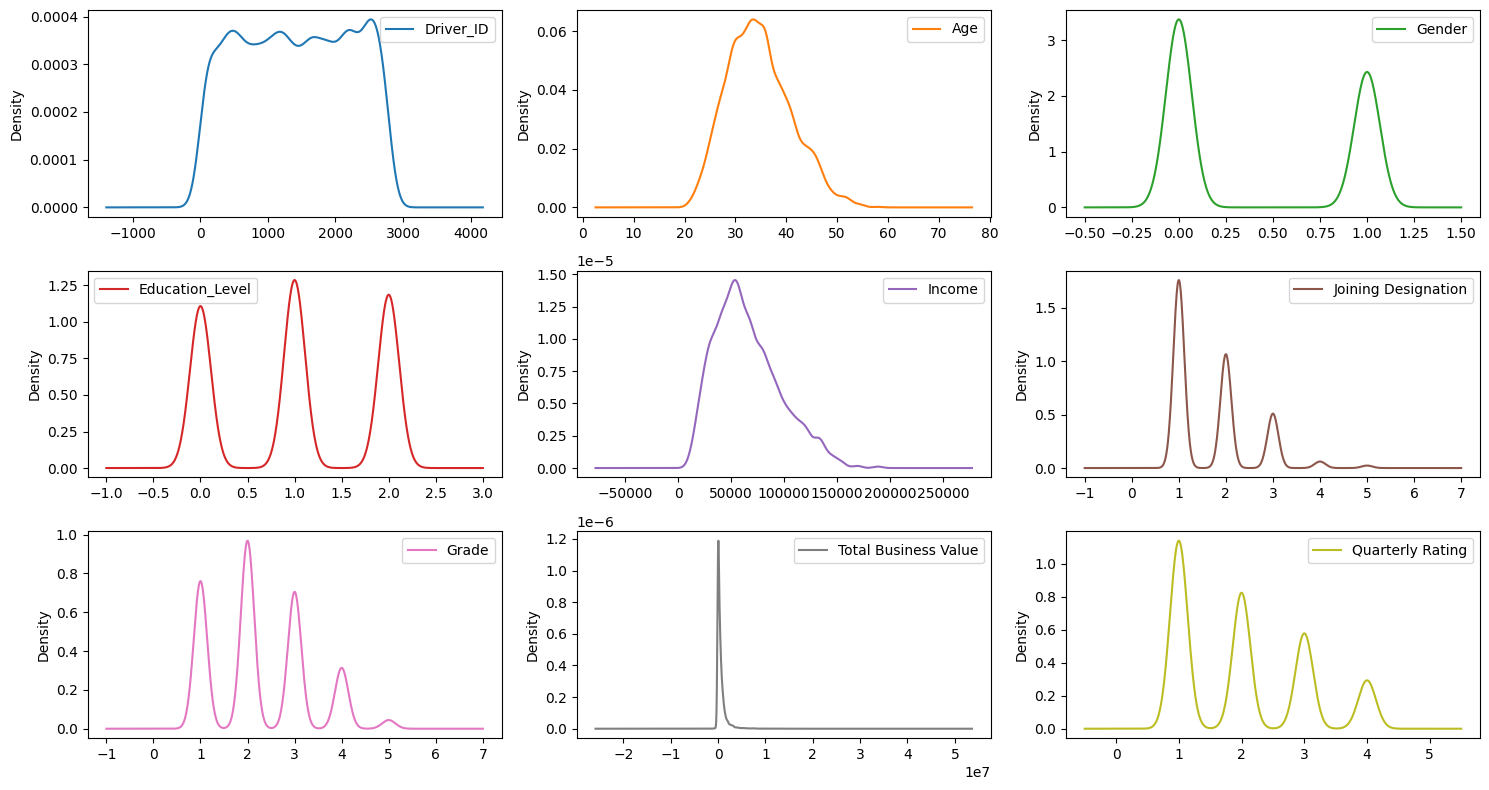

In [315]:
plt.rcParams['figure.figsize'] = (15, 8)
num_vars.plot(kind='kde', subplots=True, layout=(3,3),sharex=False)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

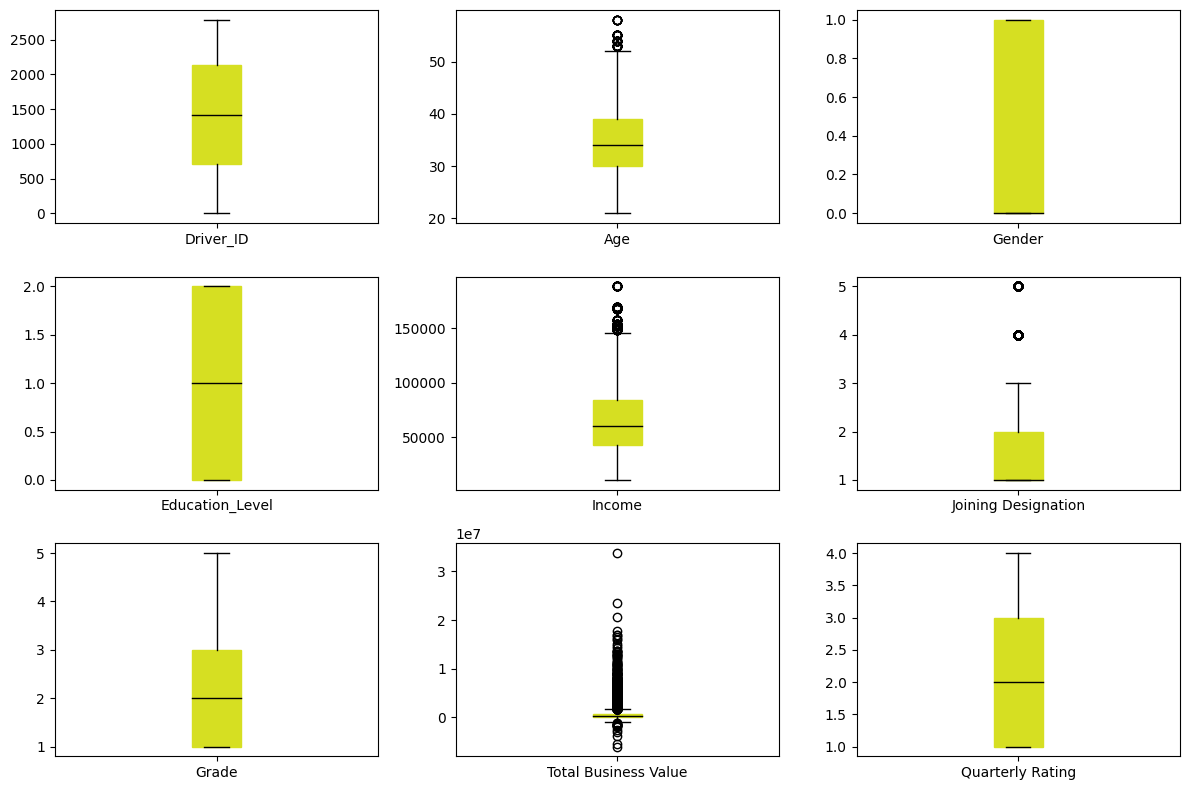

In [316]:
plt.rcParams['figure.figsize'] = (12, 8)
num_vars.plot(kind='box', subplots=True, layout=(3,3),sharex=False,color=dict(boxes='#D6DF22', whiskers='black', medians='black', caps='black'),
                     patch_artist=True)
plt.tight_layout()
plt.show()

Though the above plots shows some outliers and distribution type lets confirm them after dealing with duplicate data for drivers

# *Feature Engineering*

In [317]:
# Creating new feature to get increase or decrease in income and quarterly ratings
df['next_rating']=df.groupby('Driver_ID')['Quarterly Rating'].shift(-1)
df['next_Income']=df.groupby('Driver_ID')['Income'].shift(-1)


In [318]:
conditions=[df['next_rating']-df['Quarterly Rating']>0,
            df['next_rating']-df['Quarterly Rating']==0,
            df['next_rating']-df['Quarterly Rating']<0]

choices=[1,0,-1]
df['Ratings_increased']=np.select(conditions,choices,default=0)

In [319]:
conditions=[df['next_Income']-df['Income']>0,
            df['next_Income']-df['Income']==0,
            df['next_Income']-df['Income']<0]
df['Income_increased']=np.select(conditions,choices,default=0)

In [320]:
df['Churn']=np.where(df['LastWorkingDate'].isna(),0,1)
# df.drop(columns=['next_rating','next_Income'],inplace=True)

In [321]:
df['Quarterly Rating']=pd.Categorical(df['Quarterly Rating'],
                               categories=[1,2,3,4],
                               ordered=True)

## *Exploratory Data Analysis*

In [322]:
# Function to print basic useful details for categorial column
def get_column_details(df,column,tittle):
    print("Details of",column,"column")
    print('*'*50)

    #DataType of column
    print("\nDataType: ",df[column].dtype)
    print('*'*50)


    #Get Number of Unique Values
    print("\nNumber of Unique Values: ",df[column].nunique())
    print('*'*50)


    #Get Category counts of Column
    print(f"\nCount of Drivers {tittle} wise:\n")
    print(df[column].value_counts())
    print('*'*50)
    print(f"\nPercentage of Drivers {tittle} wise:\n")
    print(round(df[column].value_counts(normalize=True)*100,2))
    print('*'*50)

In [323]:
# @title *Reporting Month*
get_column_details(df,column='Reporting_month',tittle='Reporting Month')

Details of Reporting_month column
**************************************************

DataType:  datetime64[ns]
**************************************************

Number of Unique Values:  24
**************************************************

Count of Drivers Reporting Month wise:

Reporting_month
2019-01-01    1022
2019-02-01     944
2019-03-01     870
2020-12-01     819
2020-10-01     818
2020-08-01     812
2020-09-01     809
2020-07-01     806
2020-11-01     805
2019-12-01     795
2019-04-01     794
2020-01-01     782
2019-11-01     781
2020-06-01     770
2020-05-01     766
2019-05-01     764
2019-09-01     762
2020-02-01     761
2019-07-01     757
2019-08-01     754
2019-10-01     739
2020-04-01     729
2019-06-01     726
2020-03-01     719
Name: count, dtype: int64
**************************************************

Percentage of Drivers Reporting Month wise:

Reporting_month
2019-01-01    5.35
2019-02-01    4.94
2019-03-01    4.55
2020-12-01    4.29
2020-10-01    4.28
2020-08-0

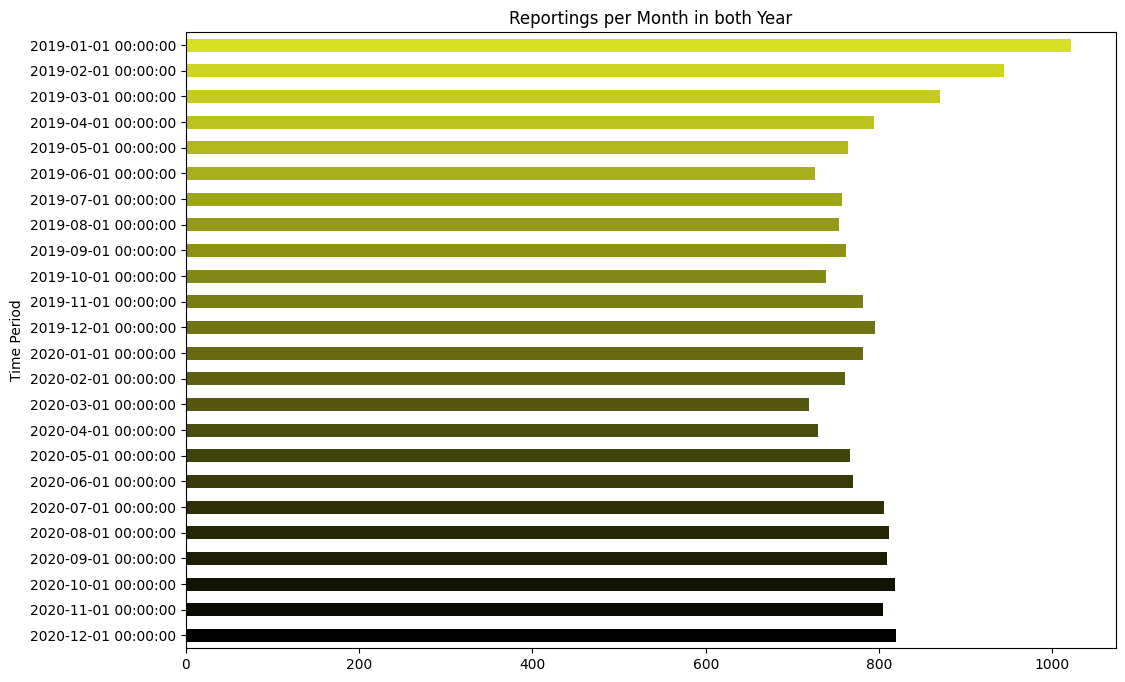

In [324]:
# Define custom colors
colors = ['#D6DF22', 'black']

# Create a gradient of 24 colors between the two
cmap_custom = LinearSegmentedColormap.from_list("custom_cmap", colors, N=24)

df['Reporting_month'].value_counts().sort_index().plot(kind='barh',color=[cmap_custom(i/24) for i in range(24)])#'#D6DF22')
plt.title('Reportings per Month in both Year')
plt.ylabel('Time Period')
plt.gca().invert_yaxis()
plt.show()


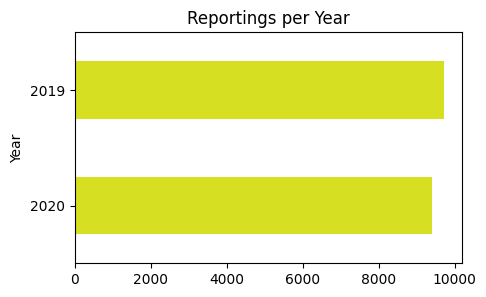

In [325]:
plt.figure(figsize=(5,3))
df['Reporting_month'].dt.year.value_counts().sort_index().plot(kind='barh',color='#D6DF22')
plt.title('Reportings per Year')
plt.ylabel('Year')
plt.gca().invert_yaxis()
plt.show()

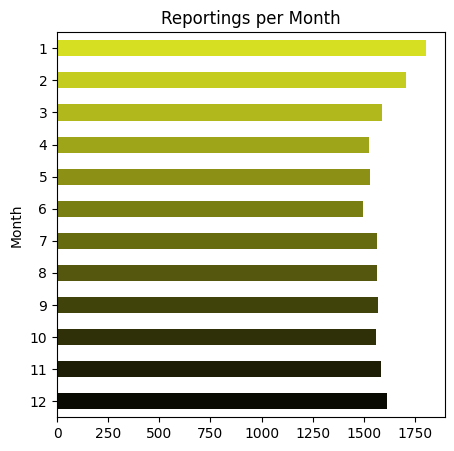

In [326]:
plt.figure(figsize=(5,5))
df['Reporting_month'].dt.month.value_counts().sort_index().plot(kind='barh',color=[cmap_custom(i/12) for i in range(12)])
plt.title('Reportings per Month')
plt.ylabel('Month')
plt.gca().invert_yaxis()
plt.show()

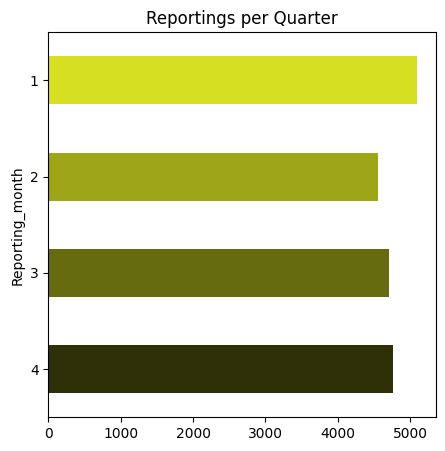

In [327]:
plt.figure(figsize=(5,5))
df['Reporting_month'].dt.quarter.value_counts().sort_index().plot(kind='barh',color=[cmap_custom(i/4) for i in range(4)])
plt.title('Reportings per Quarter')
plt.gca().invert_yaxis()
plt.show()

- The reporting per month is highest in January 2019 while it has been decreasing heavily post that.
- Though it has been stable in last months of 2020 it can be due to new joinings too.
- If we compare the yearly reportings, it is more in 2019 than 2020.
- For comparing months reportings are high in january and December but lowest in June month.
- Quarter 1 and 4 have high reportings than Q3 and Q4.

In [328]:
# @title *Driver Count*
driver_total=df.Driver_ID.nunique()
driver_left=df.groupby('Driver_ID')['LastWorkingDate'].count().sum()

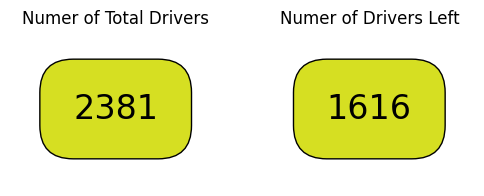

In [329]:
plt.figure(figsize=(6, 2))
plt.subplot(1,2,1)
plt.title('Numer of Total Drivers')
plt.text(0.5, 0.5,driver_total , fontsize=24, bbox=dict(facecolor='#D6DF22', edgecolor='black', boxstyle='round,pad=1'), ha='center', va='center')
plt.axis('off')

plt.subplot(1,2,2)
plt.title('Numer of Drivers Left')
plt.text(0.5, 0.5,driver_left , fontsize=24, bbox=dict(facecolor='#D6DF22', edgecolor='black', boxstyle='round,pad=1'), ha='center', va='center')
plt.axis('off')

plt.show()

In [330]:
# @title *Last Working Date*
get_column_details(df,column='LastWorkingDate',tittle='Last days')

Details of LastWorkingDate column
**************************************************

DataType:  datetime64[ns]
**************************************************

Number of Unique Values:  493
**************************************************

Count of Drivers Last days wise:

LastWorkingDate
2020-07-29    70
2019-09-22    26
2019-03-17    14
2020-11-28    13
2020-02-17    13
              ..
2019-06-16     1
2020-11-17     1
2020-12-05     1
2019-09-02     1
2020-10-28     1
Name: count, Length: 493, dtype: int64
**************************************************

Percentage of Drivers Last days wise:

LastWorkingDate
2020-07-29    4.33
2019-09-22    1.61
2019-03-17    0.87
2020-11-28    0.80
2020-02-17    0.80
              ... 
2019-06-16    0.06
2020-11-17    0.06
2020-12-05    0.06
2019-09-02    0.06
2020-10-28    0.06
Name: proportion, Length: 493, dtype: float64
**************************************************


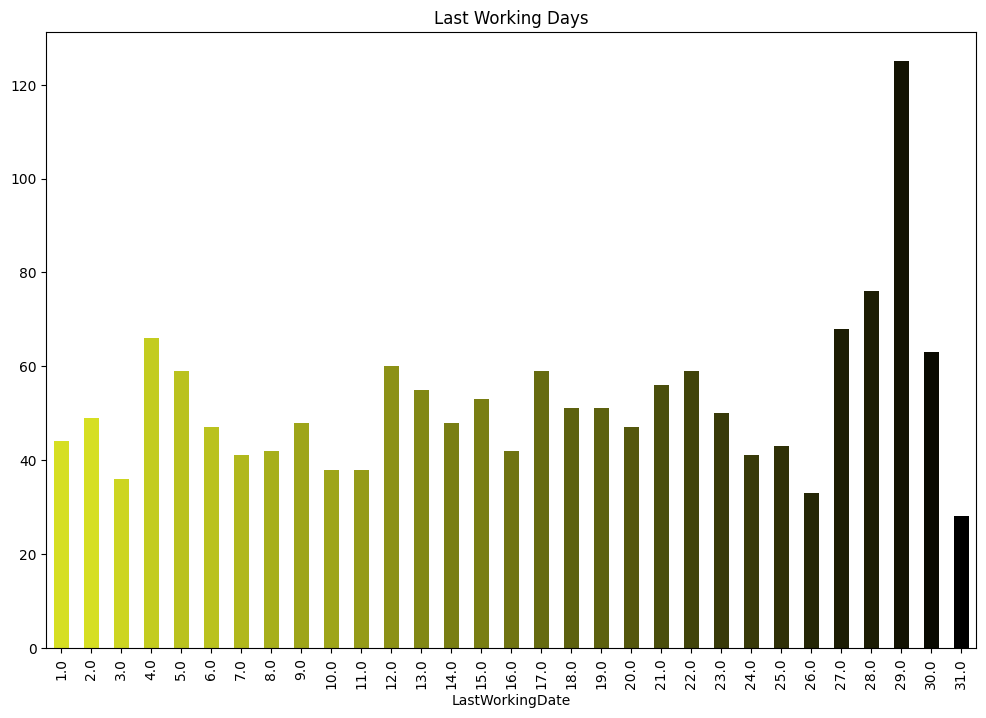

In [331]:
df['LastWorkingDate'].dt.day.value_counts().sort_index().plot(kind='bar',color=[cmap_custom(i/31) for i in range(31)])
plt.title('Last Working Days')
plt.show()

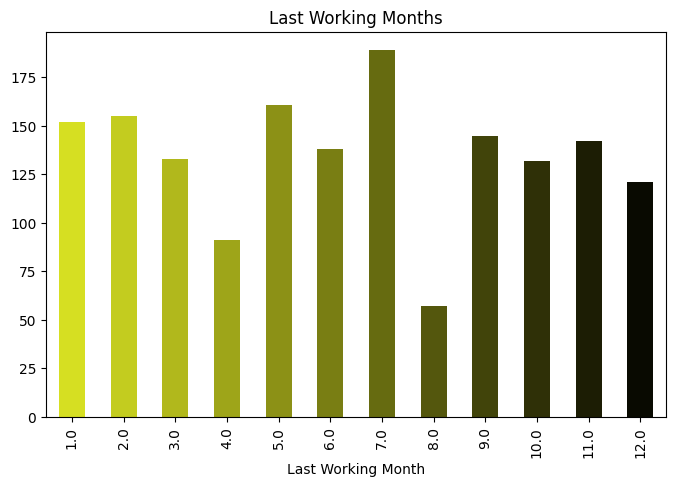

In [332]:
plt.figure(figsize=(8,5))
df['LastWorkingDate'].dt.month.value_counts().sort_index().plot(kind='bar',color=[cmap_custom(i/12) for i in range(12)])
plt.title('Last Working Months')
plt.xlabel('Last Working Month')
plt.show()

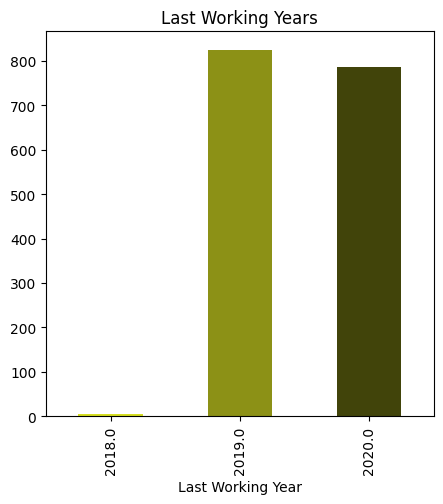

In [333]:
plt.figure(figsize=(5,5))
df['LastWorkingDate'].dt.year.value_counts().sort_index().plot(kind='bar',color=[cmap_custom(i/3) for i in range(3)])
plt.title('Last Working Years')
plt.xlabel('Last Working Year')
plt.show()

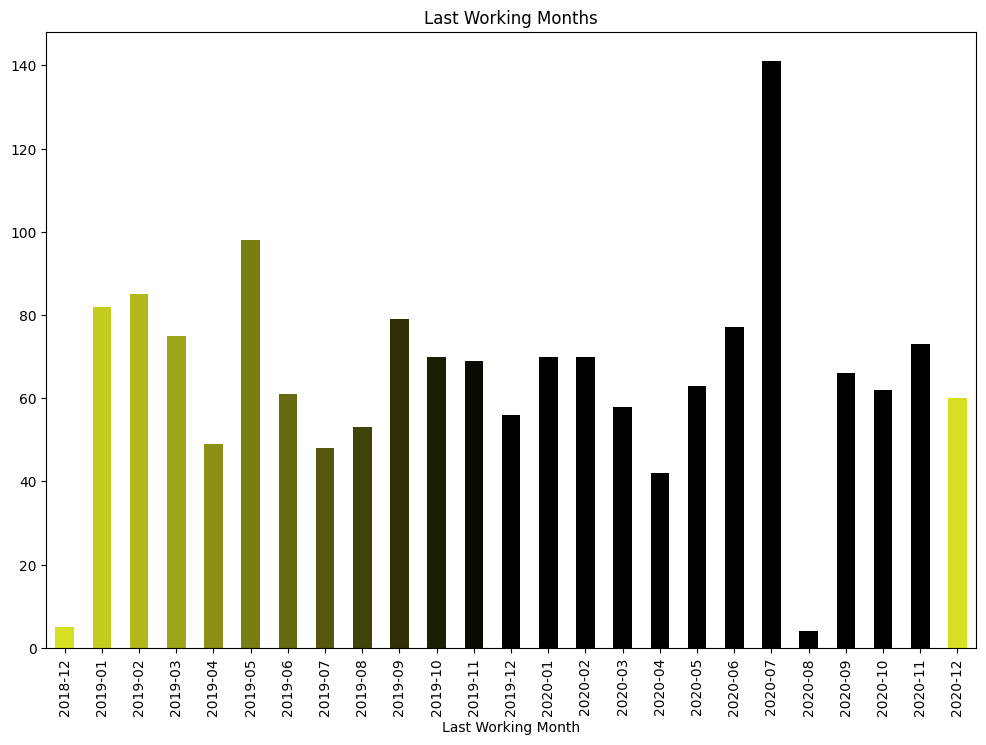

In [334]:
df['LastWorkingDate'].dt.strftime('%Y-%m').value_counts().sort_index().plot(kind='bar',color=[cmap_custom(i/12) for i in range(24)])
plt.title('Last Working Months')
plt.xlabel('Last Working Month')
plt.show()

- Total 2381 drivers data is given, out of which 1616, i.e. almost **68%** left the company.
- More drivers churned in 2019 as compared to 2020 but the difference is minimal.
- Monthwise most drivers churned in July and May while least in August and April.
- If we look at days most drivers churned in last days of the month.
- Churning was least in August 2020 while highest in July 2020.

# *Data Aggregation*

In [335]:
aggfunction={'Reporting_month':'last',
             'Age':'max',
             'Gender':'last',
             'City':'last',
             'Education_Level':'max',
            'Income':'max',
            'Dateofjoining':'last',
            'LastWorkingDate':'last',
            'Joining Designation':'last',
             'Grade':'last',
             'Total Business Value':'sum',
              'Quarterly Rating':'last',
             'Ratings_increased':'sum',
             'Income_increased':'sum',
             'Churn':'last'}

In [336]:
df_agg=df.groupby('Driver_ID').agg(aggfunction).reset_index()
df_agg.rename(columns={'Reporting_month':'Last_Reporting_month',
                       'Quarterly Rating':'Last Quarter Ratings'},inplace=True)
df_agg.head()

,Driver_ID,Last_Reporting_month,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Last Quarter Ratings,Ratings_increased,Income_increased,Churn
0,1,2019-03-01,28.0,0,C23,2,57387,2018-12-24,2019-03-11,1,1,1715580,2,0,0,1
1,2,2020-12-01,31.0,0,C7,2,67016,2020-11-06,NaT,2,2,0,1,0,0,0
2,4,2020-04-01,43.0,0,C13,2,65603,2019-12-07,2020-04-27,2,2,350000,1,0,0,1
3,5,2019-03-01,29.0,0,C9,0,46368,2019-01-09,2019-03-07,1,1,120360,1,0,0,1
4,6,2020-12-01,31.0,1,C11,1,78728,2020-07-31,NaT,3,3,1265000,2,1,0,0


## *Univariate Analysis*

In [337]:
# @title *Churn Analysis*
df_agg['Churn'].value_counts()

,count
Churn,
1,1616
0,765


In [338]:
# drivers with negative business value
driver_neg=df[df['Total Business Value']<0]['Driver_ID']
driver_neg.nunique()

136

In [339]:
df_agg[df_agg['Churn']==1]['Driver_ID'].isin(driver_neg).value_counts()

,count
Driver_ID,
False,1515
True,101


In [340]:
# drivers with zero business value
driver_zero=df_agg[df_agg['Total Business Value']==0]['Driver_ID']
driver_zero.nunique()

719

In [341]:
df_agg[df_agg['Churn']==1]['Driver_ID'].isin(driver_zero).value_counts()

,count
Driver_ID,
False,1064
True,552


- 1616 drivers churned while 765 dont.
- Total business value is negative for 136 drivers and 101 among those left the company.
- It is 0 for 719 drivers and 552 among those left the company. This can be an important feature to find churning drivers

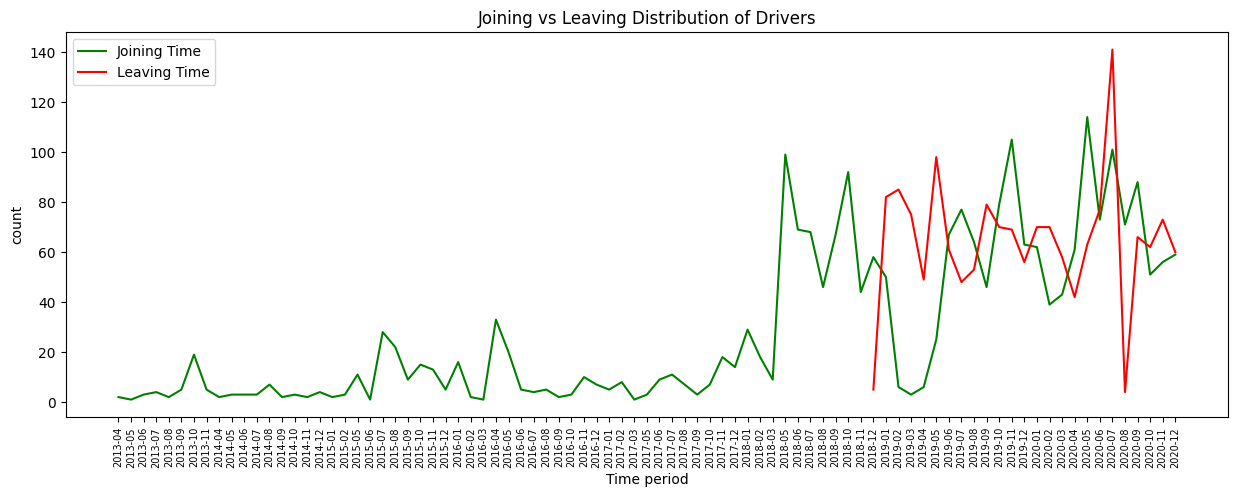

In [342]:
# @title *Comparing Joining Vs leaving*
plt.figure(figsize=(15,5))
sns.lineplot(df_agg['Dateofjoining'].dt.strftime('%Y-%m').value_counts().sort_index(),color='green',label='Joining Time')
sns.lineplot(df_agg['LastWorkingDate'].dt.strftime('%Y-%m').value_counts().sort_index(),color='red',label='Leaving Time')
plt.title('Joining vs Leaving Distribution of Drivers')
plt.xticks(rotation=90,size=7)
plt.xlabel('Time period')
plt.legend()
plt.show()

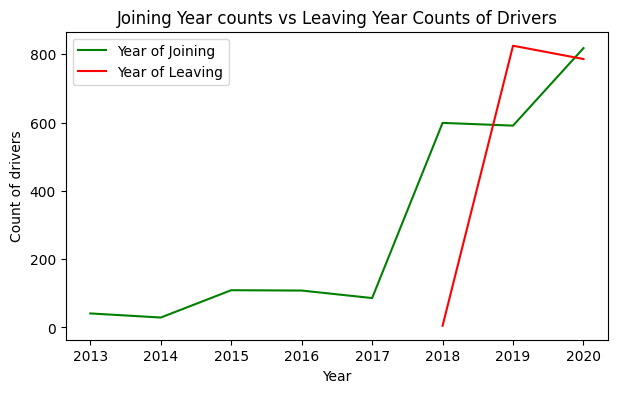

In [343]:
plt.figure(figsize=(7,4))
sns.lineplot(df_agg['Dateofjoining'].dt.year.value_counts(),color='green',label='Year of Joining')
sns.lineplot(df_agg['LastWorkingDate'].dt.year.value_counts(),color='red',label='Year of Leaving')
plt.title('Joining Year counts vs Leaving Year Counts of Drivers')
plt.xlabel('Year')
plt.ylabel('Count of drivers')
plt.legend()
plt.show()

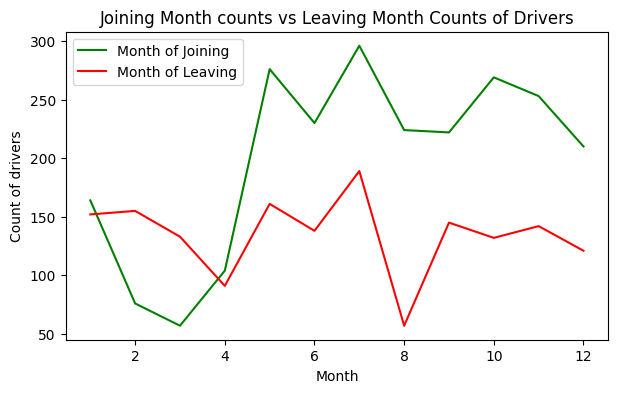

In [344]:
plt.figure(figsize=(7,4))
sns.lineplot(df_agg['Dateofjoining'].dt.month.value_counts(),color='green',label='Month of Joining')
sns.lineplot(df_agg['LastWorkingDate'].dt.month.value_counts(),color='red',label='Month of Leaving')
plt.title('Joining Month counts vs Leaving Month Counts of Drivers')
plt.xlabel('Month')
plt.ylabel('Count of drivers')
plt.legend()
plt.show()

- The data is given from 2013 till 2020 for joining drivers, who are still worling but for only those who left the company in 2019 and 2013.
- Joining period is high in March, October 2018,last months of 2019 and in mid 2020.
- These may be thereason of high churning in start of 2019, extreme in mid 2020.
- Cant comment on attrition before 2018 because no data id given but as joining increased drastically after 2017 alongwith churning which is at peak in 2019, it bells alarms.
- Joining and churning moving together, if we look at month curves, which shows company is trying to keep its work regular though it wont work unless the driver will start staying.

Text(0.5, 1.0, 'Distribution of Working Months')

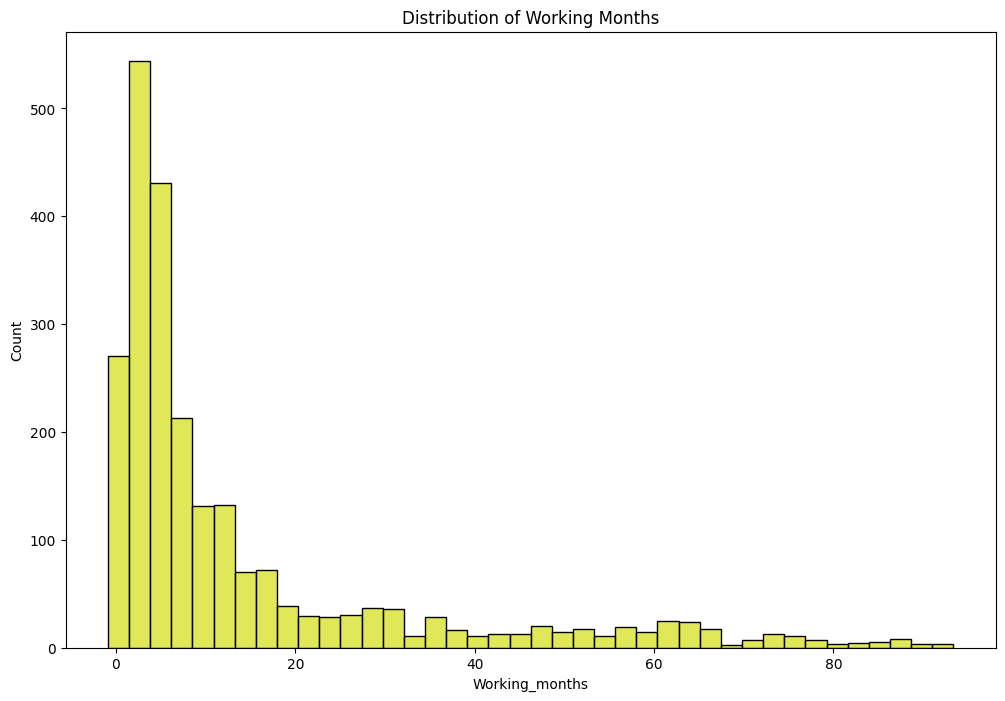

In [345]:
# @title *Feature Engineering*

# Finding the tenure of drivers
df_agg['Working_months']=df_agg['Last_Reporting_month']-df_agg['Dateofjoining']
df_agg['Working_months']=(df_agg['Working_months'].dt.days/30).round(2)
sns.histplot(df_agg['Working_months'],bins=40,color='#D6DF22')
plt.title('Distribution of Working Months')

In [346]:
# @title *Gender Analysis*
get_column_details(df_agg,'Gender',tittle='Gender')

Details of Gender column
**************************************************

DataType:  category
**************************************************

Number of Unique Values:  2
**************************************************

Count of Drivers Gender wise:

Gender
0    1404
1     977
Name: count, dtype: int64
**************************************************

Percentage of Drivers Gender wise:

Gender
0    58.97
1    41.03
Name: proportion, dtype: float64
**************************************************


In [347]:
data=df_agg['Gender'].value_counts()

fig = go.Figure(data=[go.Pie(
    labels=['Male  ','Female  '],
    values=data.values,
    hole=0.4,
    hoverinfo='label+value',  # Show label, value, and percentage on hover
    textinfo='percent',  # Don't show text inside slices
    textfont=dict(size=12,weight='bold'),  # Font size for the percentage text on the chart
    hoverlabel=dict(
        font=dict(size=16)  # Font size for the hover text
    ),
    marker=dict(colors=['#D6DF22', 'black'],line=dict(width=2, color='darkgrey')),  # Slice colors and shadow effect
    pull=[0, 0.1],  # Explode the second slice (female)
    rotation=180
)])
fig.update_traces(marker=dict(line=dict(width=2, color='darkgrey')))

# Update # title specifications layout
fig.update_layout(title=dict(
        text='Gender Distribution of Drivers',
        font=dict(size=24, color='black', family='Arial', weight='bold'),
        x=0.5,  # Center the title
        xanchor='center'  # Anchor the title to the center
    ),showlegend=True,width=500, height=500)

fig.show()


In [348]:
# @title *City Analysis*
get_column_details(df_agg,'City',tittle='City')

Details of City column
**************************************************

DataType:  object
**************************************************

Number of Unique Values:  29
**************************************************

Count of Drivers City wise:

City
C20    152
C15    101
C29     96
C26     93
C8      89
C27     89
C10     86
C16     84
C22     82
C3      82
C28     82
C12     81
C5      80
C1      80
C21     79
C14     79
C6      78
C4      77
C7      76
C9      75
C25     74
C23     74
C24     73
C19     72
C2      72
C17     71
C13     71
C18     69
C11     64
Name: count, dtype: int64
**************************************************

Percentage of Drivers City wise:

City
C20    6.38
C15    4.24
C29    4.03
C26    3.91
C8     3.74
C27    3.74
C10    3.61
C16    3.53
C22    3.44
C3     3.44
C28    3.44
C12    3.40
C5     3.36
C1     3.36
C21    3.32
C14    3.32
C6     3.28
C4     3.23
C7     3.19
C9     3.15
C25    3.11
C23    3.11
C24    3.07
C19    3.02
C2     3.02
C17 

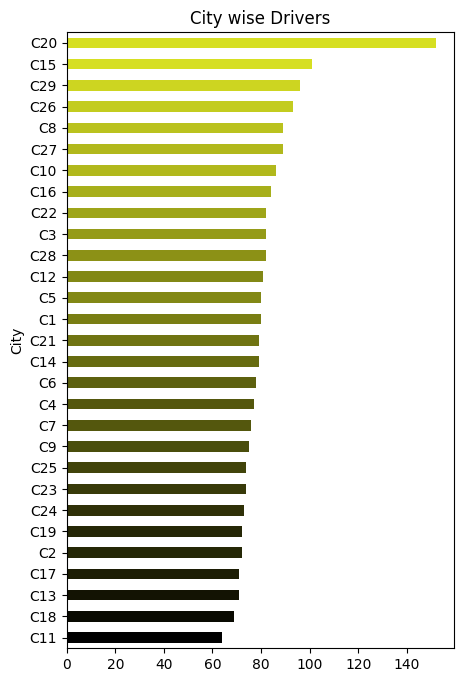

In [349]:
plt.figure(figsize=(5,8))
df_agg['City'].value_counts().plot(kind='barh',color=[cmap_custom(i/29) for i in range(29)])
plt.title('City wise Drivers')
plt.gca().invert_yaxis()
plt.show()

In [350]:
# @title *Education Level Analysis*
get_column_details(df_agg,'Education_Level',tittle='Education Level')

Details of Education_Level column
**************************************************

DataType:  category
**************************************************

Number of Unique Values:  3
**************************************************

Count of Drivers Education Level wise:

Education_Level
2    802
1    795
0    784
Name: count, dtype: int64
**************************************************

Percentage of Drivers Education Level wise:

Education_Level
2    33.68
1    33.39
0    32.93
Name: proportion, dtype: float64
**************************************************


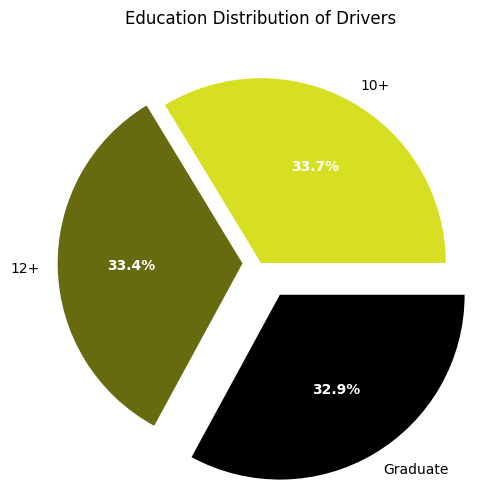

In [351]:
data=df_agg['Education_Level'].value_counts()

plt.figure(figsize=(6,6))
# Create pie chart
wedges, texts, autotexts = plt.pie(data, autopct='%1.1f%%', explode=[0, 0.1,0.2], colors=cmap_custom(np.linspace(0, 1, 3)),labels=['10+','12+','Graduate'],
                                    textprops={'color': 'black'}, labeldistance=1.1)

# Customize percentage labels
for autotext in autotexts:
    autotext.set_color('white')  # Set the color of percentage text to white
    autotext.set_fontweight('bold')  # Set the font weight of percentage text to bold

# Set the title
plt.title('Education Distribution of Drivers')
plt.show()

In [352]:
# @title *Joining Designation Analysis*
get_column_details(df_agg,'Joining Designation',tittle='Joining Designation')

Details of Joining Designation column
**************************************************

DataType:  category
**************************************************

Number of Unique Values:  5
**************************************************

Count of Drivers Joining Designation wise:

Joining Designation
1    1026
2     815
3     493
4      36
5      11
Name: count, dtype: int64
**************************************************

Percentage of Drivers Joining Designation wise:

Joining Designation
1    43.09
2    34.23
3    20.71
4     1.51
5     0.46
Name: proportion, dtype: float64
**************************************************


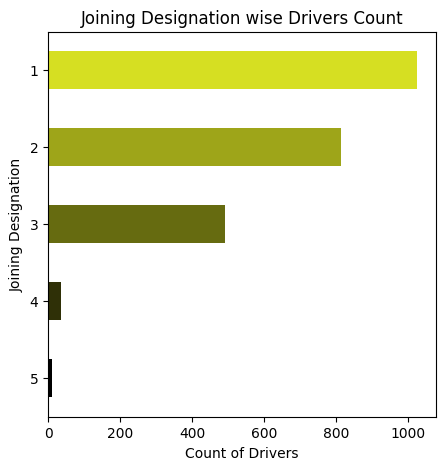

In [353]:
plt.figure(figsize=(5,5))
df_agg['Joining Designation'].value_counts().plot(kind='barh',color=cmap_custom(np.linspace(0,1,5)))
plt.title('Joining Designation wise Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

In [354]:
# @title *Grade Analysis*
get_column_details(df_agg,'Grade',tittle='Grade')

Details of Grade column
**************************************************

DataType:  category
**************************************************

Number of Unique Values:  5
**************************************************

Count of Drivers Grade wise:

Grade
2    855
1    741
3    623
4    138
5     24
Name: count, dtype: int64
**************************************************

Percentage of Drivers Grade wise:

Grade
2    35.91
1    31.12
3    26.17
4     5.80
5     1.01
Name: proportion, dtype: float64
**************************************************


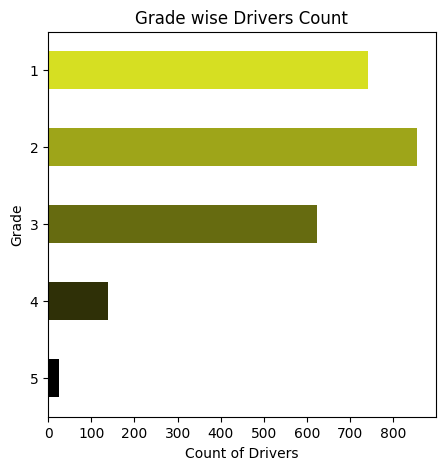

In [355]:
plt.figure(figsize=(5,5))
df_agg['Grade'].value_counts().sort_index().plot(kind='barh',color=cmap_custom(np.linspace(0,1,5)))
plt.title('Grade wise Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

In [356]:
# @title *Quarterly Rating Analysis*
get_column_details(df_agg,'Last Quarter Ratings',tittle='Quarterly Ratings')

Details of Last Quarter Ratings column
**************************************************

DataType:  category
**************************************************

Number of Unique Values:  4
**************************************************

Count of Drivers Quarterly Ratings wise:

Last Quarter Ratings
1    1744
2     362
3     168
4     107
Name: count, dtype: int64
**************************************************

Percentage of Drivers Quarterly Ratings wise:

Last Quarter Ratings
1    73.25
2    15.20
3     7.06
4     4.49
Name: proportion, dtype: float64
**************************************************


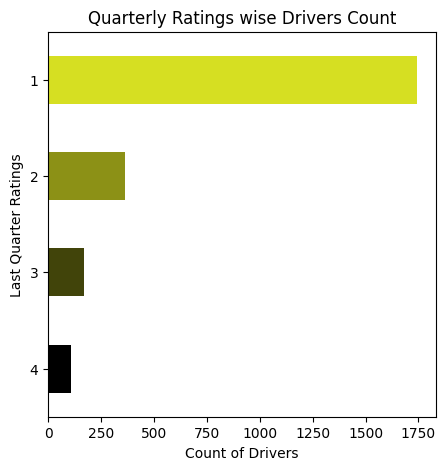

In [357]:
plt.figure(figsize=(5,5))
df_agg['Last Quarter Ratings'].value_counts().sort_index().plot(kind='barh',color=cmap_custom(np.linspace(0,1,4)))
plt.title('Quarterly Ratings wise Drivers Count')
plt.xlabel('Count of Drivers')
plt.gca().invert_yaxis()
plt.show()

In [358]:
# @title *Ratings Change Analysis*
get_column_details(df_agg,'Ratings_increased',tittle='Ratings increased')

Details of Ratings_increased column
**************************************************

DataType:  int64
**************************************************

Number of Unique Values:  7
**************************************************

Count of Drivers Ratings increased wise:

Ratings_increased
 0    1614
-1     361
 1     274
 2      60
-2      58
-3      10
 3       4
Name: count, dtype: int64
**************************************************

Percentage of Drivers Ratings increased wise:

Ratings_increased
 0    67.79
-1    15.16
 1    11.51
 2     2.52
-2     2.44
-3     0.42
 3     0.17
Name: proportion, dtype: float64
**************************************************


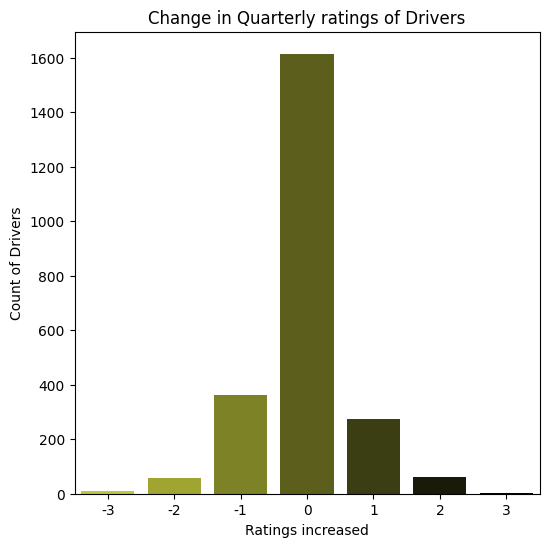

In [359]:
plt.figure(figsize=(6,6))
plt.title('Change in Quarterly ratings of Drivers')
sns.countplot(x='Ratings_increased',data=df_agg,palette=cmap_custom(np.linspace(0,1,7)))
plt.xlabel('Ratings increased')
plt.ylabel('Count of Drivers')
plt.show()

In [360]:
# @title *Income Change Analysis*
get_column_details(df_agg,'Income_increased',tittle='Income increased')

Details of Income_increased column
**************************************************

DataType:  int64
**************************************************

Number of Unique Values:  2
**************************************************

Count of Drivers Income increased wise:

Income_increased
0    2338
1      43
Name: count, dtype: int64
**************************************************

Percentage of Drivers Income increased wise:

Income_increased
0    98.19
1     1.81
Name: proportion, dtype: float64
**************************************************


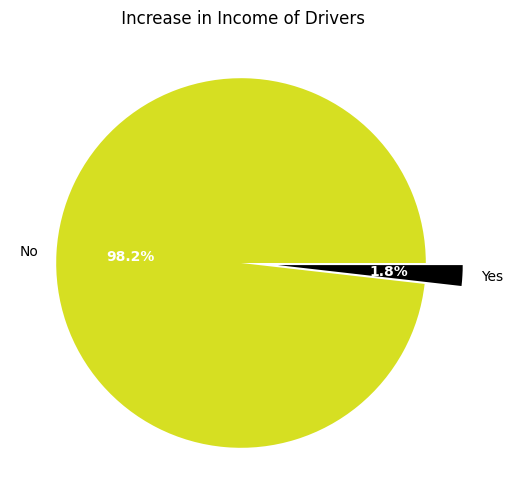

In [361]:
plt.figure(figsize=(6,6))
plt.title(' Increase in Income of Drivers')
wedges, axis, autotexts=plt.pie(df_agg['Income_increased'].value_counts(),autopct='%1.1f%%',explode=[0,0.2],colors=cmap_custom(np.linspace(0,1,2)),\
        labels=['No','Yes'],textprops={'color': 'black'}, labeldistance=1.1)

for autotext in autotexts:
    autotext.set_color('white')  # Set the color of percentage text to white
    autotext.set_fontweight('bold')  # Set the font weight of percentage text to bold

plt.show()

- The high number of employees are having very less tenure below 1 year, and those staying for long are very low, which is again alarming and worrysome too.
- Out of 2381 employees, 1404 employees are males and 977 are females.
-  Out of total employees, 152 employees are from city C20 and 101 from city C15 and the least from cities 11,18 and 13.
- Out of total employees, 802 employees have completed their graduation and 795 have completed their 12th while 784 completed till Higher Secondary only.
- Out of total employees, 1026 joined on designation 1, 815 employees joined on designation 2 and as grade increases the number reduces, which makes sense too as higher grade employees used to be less in organisations.
- Out of total employees, 855 employees had their grade as 2 at the time of reporting, 741 as 2 while only 24 as grade 5.
- Out of total employees, 1744 employees had their last quarterly rating as 1, while the number is decreasing as moving towards higher ratings.It decreased drastically to 362 for ratimg 1 and 168 and 107 to ratings 3 and 4, no driver is at rating 5.
- Out of total employees, the quarterly rating has not increased for 1614(68% employees.It reduced for 429 employees, infact for 58 employees, 2 times and for 10 even 3 times ratings has been reduced.
- Though their are good employees(274) too whose ratings has been increase once, for 60 - twice and only for 4 it is increased to 3 times even.
- out of total employees, for 2338(98%+) employees there is no change in income, which can be a potential sign of churning as those who are working from last 2-3 years may be expecting some income hikes which is there for 43 employees only, so they left the company if get better salary.


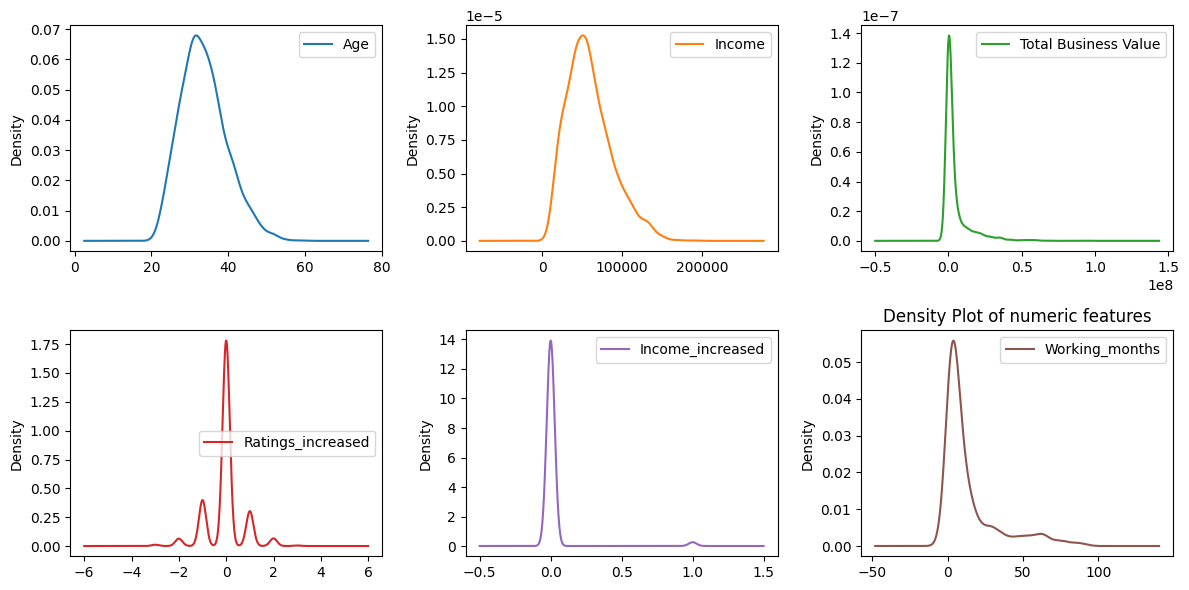

In [362]:
# @title *Numerical Features Analysis*
num_col=df_agg.select_dtypes(np.number).columns
num_col=num_col.drop(['Driver_ID','Churn'])
plt.rcParams['figure.figsize'] = (12, 6)
df_agg[num_col].plot(kind='kde',subplots=True,layout=(2,3),sharex=False)
plt.title('Density Plot of numeric features')
plt.tight_layout()
plt.show()

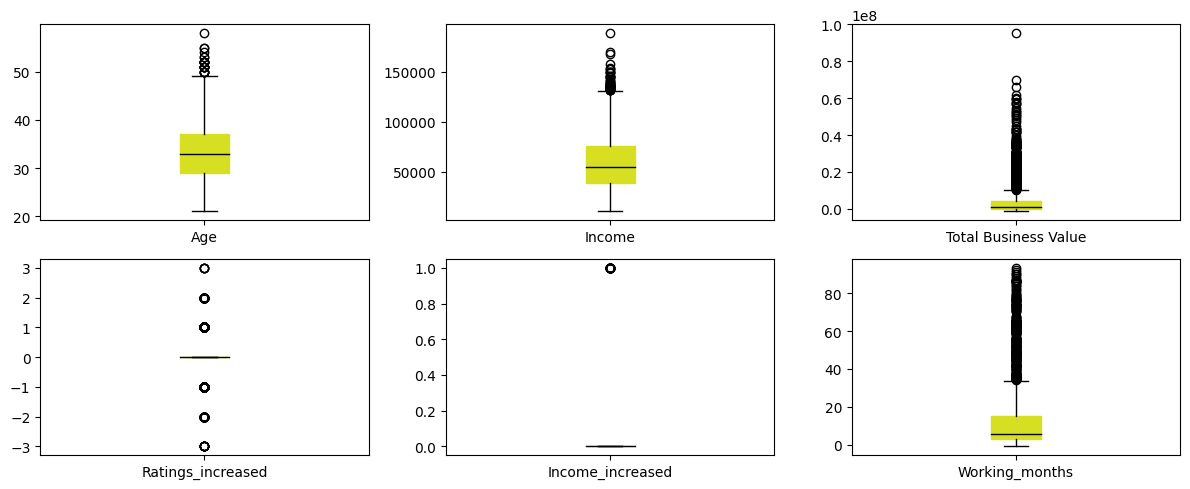

In [363]:
# @title *Detecting Outliers*
plt.rcParams['figure.figsize'] = (12, 5)
# Plotting the boxplot with filled boxes
df_agg[num_col].plot(kind='box', subplots=True, layout=(2, 3), sharex=False, \
                     color=dict(boxes='#D6DF22', whiskers='black', medians='black', caps='black'), patch_artist=True)

plt.tight_layout()
plt.show()

In [364]:
# @title *Outlier Treatment*
df_agg['Age']=np.clip(df_agg['Age'],20,np.percentile(df_agg['Age'],95))
df_agg['Income']=np.clip(df_agg['Income'],0,np.percentile(df_agg['Income'],95))
df_agg['Total Business Value']=np.clip(df_agg['Total Business Value'],df_agg['Total Business Value'].min(),np.percentile(df_agg['Total Business Value'],95))
df_agg['Working_months']=np.clip(df_agg['Working_months'],0,np.percentile(df_agg['Working_months'],95))

- The distribution of age slightly skewed on right which might indicate the outliers in the data(high age people) while average age of employees is approx **33** which shows mostly employees are young.
- The distribution of monthly income skewed on right which might indicate the outliers in the data i.e. employees who are earning quite high than other employees.
- The distribution of total business value highly skewed on right which might indicate the outliers in the data and shows there are many drivers who are earning more ,should give them some incentives or awards for their performance,
though it can be due to more number of working months too so need to dive deep into the reason for that.
- The working months also skewed towards right which indicates very less employees are working for long time and very high for less number of months.
<br><br><br>

## *Statistical Summary of aggregated Data*

In [365]:
df_agg.describe().T

,count,mean,min,25%,50%,75%,max,std
Driver_ID,2381.0,1397.559009,1.0,695.0,1400.0,2100.0,2788.0,806.161628
Last_Reporting_month,2381,2020-03-31 15:04:09.475010560,2019-01-01 00:00:00,2019-09-01 00:00:00,2020-06-01 00:00:00,2020-12-01 00:00:00,2020-12-01 00:00:00,NaN
Age,2381.0,33.527089,21.0,29.0,33.0,37.0,45.0,5.654904
Income,2381.0,58539.032759,10747.0,39104.0,55315.0,75986.0,113807.0,26404.699529
Dateofjoining,2381,2019-02-08 07:14:50.550189056,2013-04-01 00:00:00,2018-06-29 00:00:00,2019-07-21 00:00:00,2020-05-02 00:00:00,2020-12-28 00:00:00,NaN
LastWorkingDate,1616,2019-12-21 20:59:06.534653440,2018-12-31 00:00:00,2019-06-06 00:00:00,2019-12-20 12:00:00,2020-07-03 00:00:00,2020-12-28 00:00:00,NaN
Total Business Value,2381.0,3948889.895002,-1385530.0,0.0,817680.0,4173650.0,23471030.0,6599779.33701
Ratings_increased,2381.0,-0.042419,-3.0,0.0,0.0,0.0,3.0,0.718517
Income_increased,2381.0,0.01806,0.0,0.0,0.0,0.0,1.0,0.133195
Churn,2381.0,0.678706,0.0,0.0,1.0,1.0,1.0,0.467071


In [366]:
df_agg.describe(include=['object','category']).T

,count,unique,top,freq
Gender,2381,2,0,1404
City,2381,29,C20,152
Education_Level,2381,3,2,802
Joining Designation,2381,5,1,1026
Grade,2381,5,2,855
Last Quarter Ratings,2381,4,1,1744


- **Driver Age**: The average age of drivers is 33.5 years, with most drivers falling between 29 and 37 years old. The youngest driver is 21, and the oldest is 45 after ouliers removal.
- **Income**: The average monthly income is around 58.5K, with significant variation. The lowest income is 10.7K, while the highest reaches 113.8K and that too after outliers removal.
- **Business Value**: Drivers generate an average total business value of around 3.95M, but this varies greatly, with some drivers even having negative values (losses).
- **Churn Rate**: Approximately 68% of drivers have churned, indicating a high attrition rate in the company.
- **Working Tenure**: On average, drivers work for 13.4 months, with a range from 0 to 61 months.
- **Ratings & Income Increase**: Minimal growth in ratings (-0.04 on average) and income (only 1.8% experienced income growth), reflecting stagnation in driver performance and earnings.
- **Gender**: Of the 2,381 drivers, the majority (59%) are male (coded as '0'), with 1,404 drivers.
- **City**: Drivers are spread across 29 cities, with 'C20' being the most common city, having 152 drivers.
- **Education Level**: The majority of drivers (33.7%) have an education level of '2', with 802 drivers.
- **Joining Designation**: Most drivers (43.1%) joined at designation '1', representing 1,026 drivers.
- **Grade**: Grade '2' is the most common, with 855 drivers (35.9%).
- **Quarterly Rating**: The majority (73.2%) of drivers have a quarterly rating of '1', indicating lower performance for many drivers.

## *Bivariate Analysis*

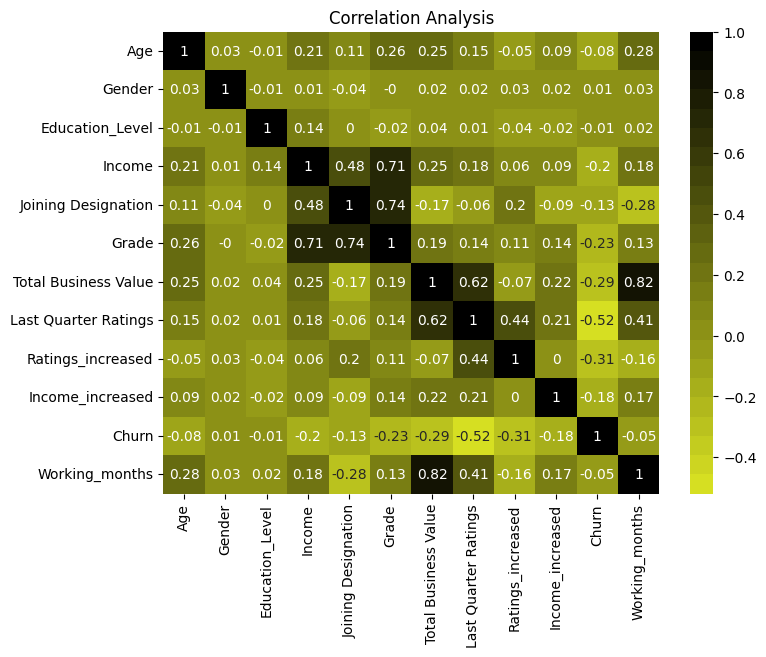

In [367]:
# @title *Correlation Analysis*
plt.figure(figsize=(8,6))
num_col=df_agg.select_dtypes(['int64','float64','category']).columns
num_col=num_col.drop(['Driver_ID'])
sns.heatmap(df_agg[num_col].corr(method='spearman').round(2),annot=True,cmap=cmap_custom)
plt.title('Correlation Analysis')
plt.show()

- **Age** has moderate positive correlations with **Income** (0.21), **Grade** (0.26), **Total Business Value** (0.25), and **Working Months** (0.28), suggesting that older drivers tend to have higher income, grades, and business value, and longer tenure.
- **Income** is highly correlated with **Grade** (0.72) and **Joining Designation** (0.48), showing that higher grades and joining positions relate to higher incomes. It also has a notable correlation with **Total Business Value** (0.25), indicating that income is connected to business performance.
- **Total Business Value** is strongly correlated with **Quarterly Rating** (0.62) and **Working Months** (0.82), reflecting that drivers who generate more business tend to have better ratings and longer tenure.
- **Last Quarter Ratings** shows a moderate positive correlation with **Total Business Value** (0.62) and **Ratings Increased** (0.44), meaning higher ratings are generally linked with business output and improved ratings over time.
- **Churn** is negatively correlated with **Total Business Value** (-0.29), **Quarterly Rating** (-0.52), and **Ratings Increased** (-0.31), showing that drivers who perform better or have increasing ratings are less likely to leave.
- **Working Months** has strong correlations with **Total Business Value** (0.82) and moderate correlations with **Income** (0.18) and **Quarterly Rating** (0.41), suggesting that longer tenure contributes to better performance and higher income.

Overall, performance (ratings, business value) and tenure are critical drivers of higher income and lower churn.

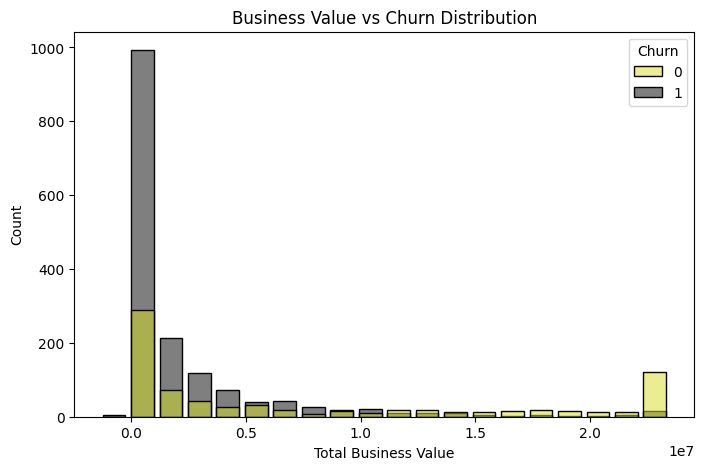

In [368]:
# @title *Total Business Value vs Churn*
plt.figure(figsize=(8,5))
sns.histplot( x=df_agg['Total Business Value'], palette=['#D6DF22','black'], hue=df_agg['Churn'],bins=20, shrink=.8)
plt.title('Business Value vs Churn Distribution')
plt.show()

- Average Total Business Value is 7.86 million for non churn drivers, significantly higher than those who churned(2.10 million).
- Drivers who do not churn have more stable and significantly higher business value, indicating that top performers are less likely to leave while underperforming drivers are more prone to attrition, potentially due to dissatisfaction or misalignment with company incentives.
- There is a wide variability in performance among non-churned drivers, meaning some non-churners excel far beyond the average, contributing immensely to business success.
- Although most churned drivers have lower business value, a few still contribute significantly before leaving, indicating that the company could lose high performers due to churn, which warrants further investigation into retention strategies for these top contributors.
- But this can also be due to more number of drivers leaving and not serving for long time that their business value is less.
- Non-churned drivers tend to generate significantly higher business value, indicating that better-performing drivers are more likely to stay.

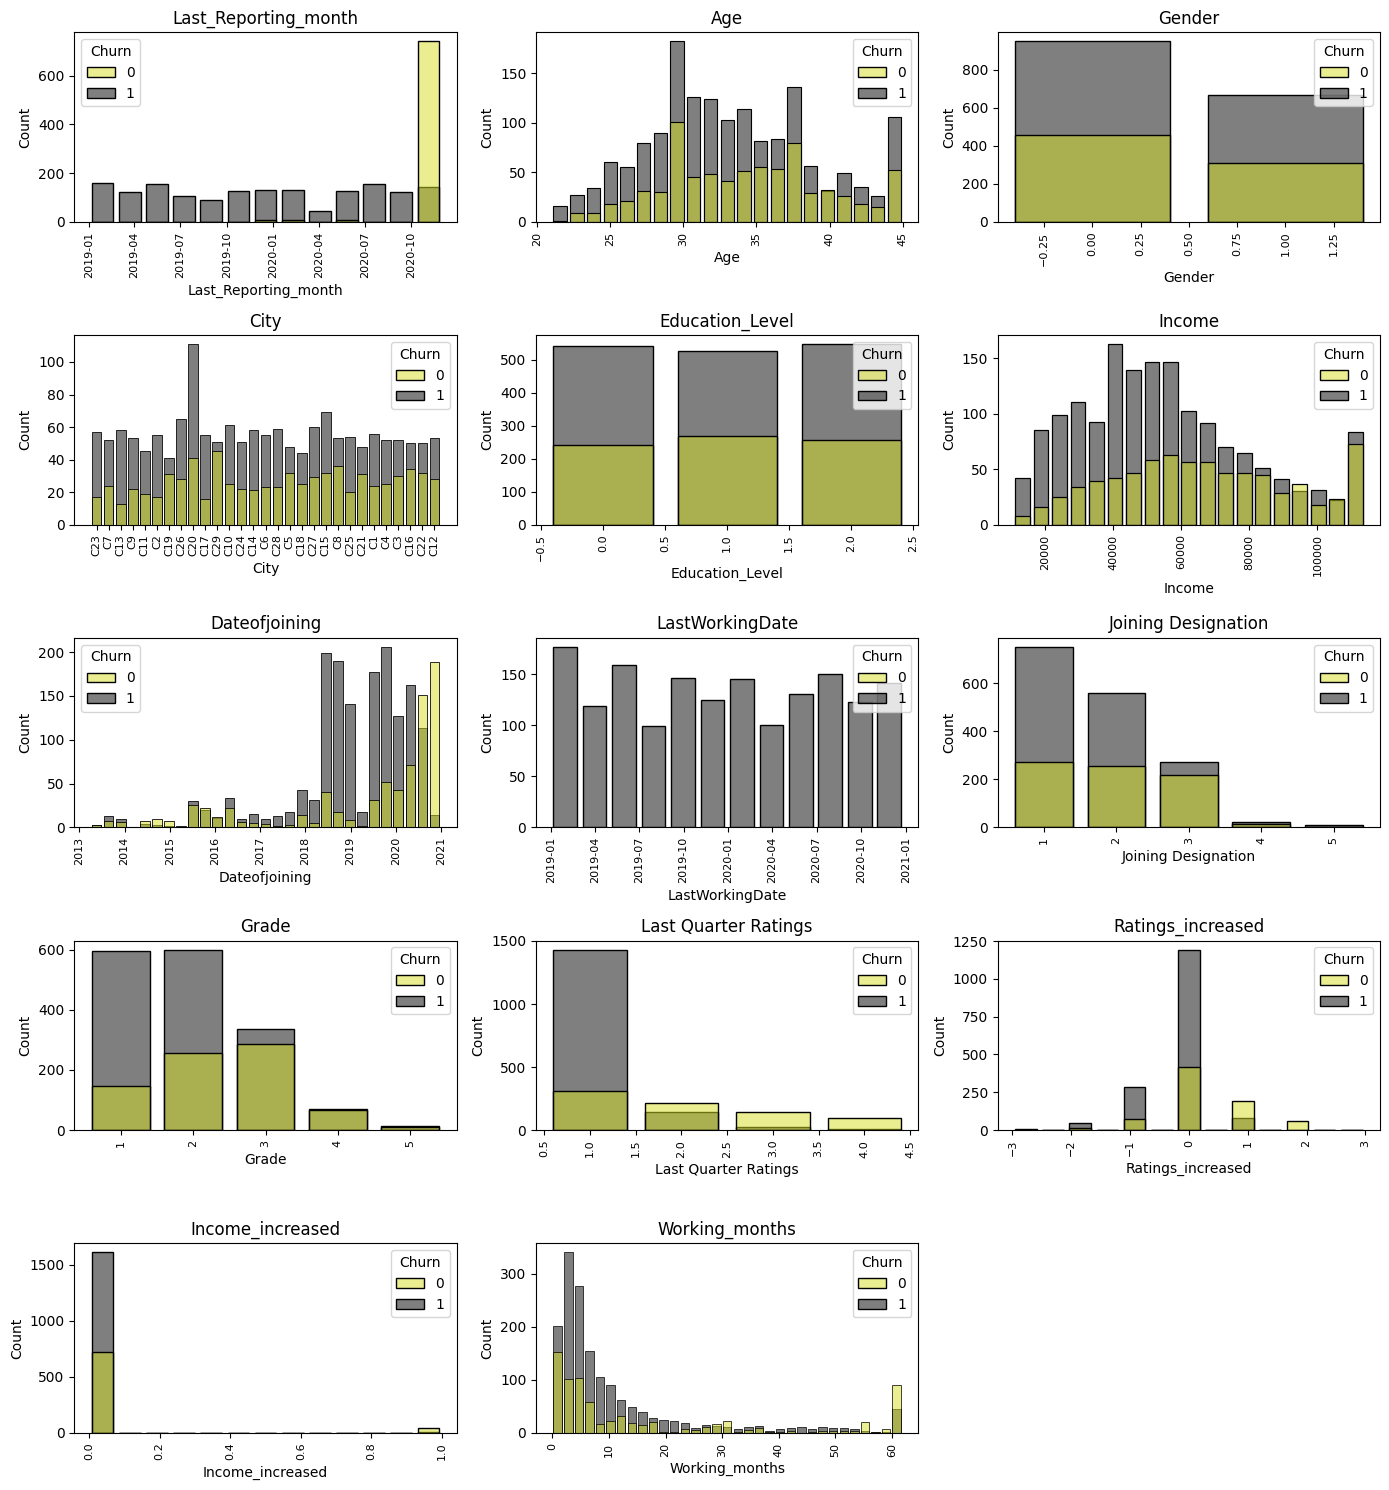

In [369]:
# @title *Different Features vs Churn*
columns=df_agg.columns.drop(['Churn','Driver_ID','Total Business Value'])
plt.figure(figsize=(14,15))
for i,col in enumerate(columns):
  plt.subplot(5,3,i+1)
  sns.histplot(x=df_agg[col],hue=df_agg['Churn'],palette=['#D6DF22','black'],shrink=.8)
  plt.title(col)
  plt.xticks(rotation=90,size=8)
plt.tight_layout()
plt.show()

*   **Reporting Month**:
  - It can be seen that there are some drivers even who didnt report after a tim eperiod but there last working day is not shown, they can be either on leave, or on hold or some data inconsistency.
  - If these drivers are thinking about leaving company should approach them for retaining.
* **Age**
  - Churned drivers tend to be slightly younger on average with high attrition till 38 years age, suggesting that younger drivers may face more challenges or have different expectations.
  - Non-churned drivers show a bit more stability in age as less attrition comparatively after 40, which might correlate with higher retention in more experienced or mature demographics.  
* **Gender, Education Level**
  - In both genders churn rate is quite similar almost 67-68%, showing no impact of gender basically.
  - No impact of education level too on Churning
* **City**
  - Cities like C20 have the highest number of churned drivers (111), suggesting potential issues in driver satisfaction or operational challenges.
  - Cities such as C15 (69 churned drivers) and C26 (65 churned) also indicate high churn, which could signal underlying factors like inadequate support or compensation issues.
  - Conversely, cities like C5,C19 a and C29 have relatively balanced churn rates, implying a need to investigate city-specific influences, such as local demand or working conditions, to better manage attrition. This may indicate favorable working conditions, high demand, or better alignment with driver expectations in these cities.
* **Income**
  - With increase in income churn rate is decreasing which shows attrition can be the sign of less salary or more salary expectations.
* **Joining Time**
  - Employees joining in 2013- 2017 are still loyal as attrition rate is not that high for those drivers but for those who joined from 2018, it is too high.
* **Joining Designation**
  - Foe employees joined on designation 1 the attrition rate is 73% while it decreases to 68% and 55% for 2 and 3 desination.
  - Though it is high again for designation 4 and 5 (36 and 11 respectively) but it may be due to very less drivers at that designation that results are skewed.
* **Grade**  
  - Attrition rate for grade 1 and 2 employees are 80 and 70 % respectively while it is low for grade 3,4 and 5 grade(near to 50%).
* **Last Quarter Ratings**
  - Attrition rate is 82% for 1 rating driver, while it decreased signficantly 40%, 16% and 9% for 2,3 and 4 ratings rivers respectively.
* **Ratings and Income Changed**
  - Drivers whose rating is either decreased or remained same are more likely to churn than those whose ratings improved with time.
  - The drivers whose incomw has been increased stayed in the company with 93% attrition which is a positive sign.
* **Working Month**
  - Retention rate is high where drivers worked in company for near to 5 years else the attrition is high.   

    

## *Multivariate Analysis*

<Figure size 1400x1500 with 0 Axes>

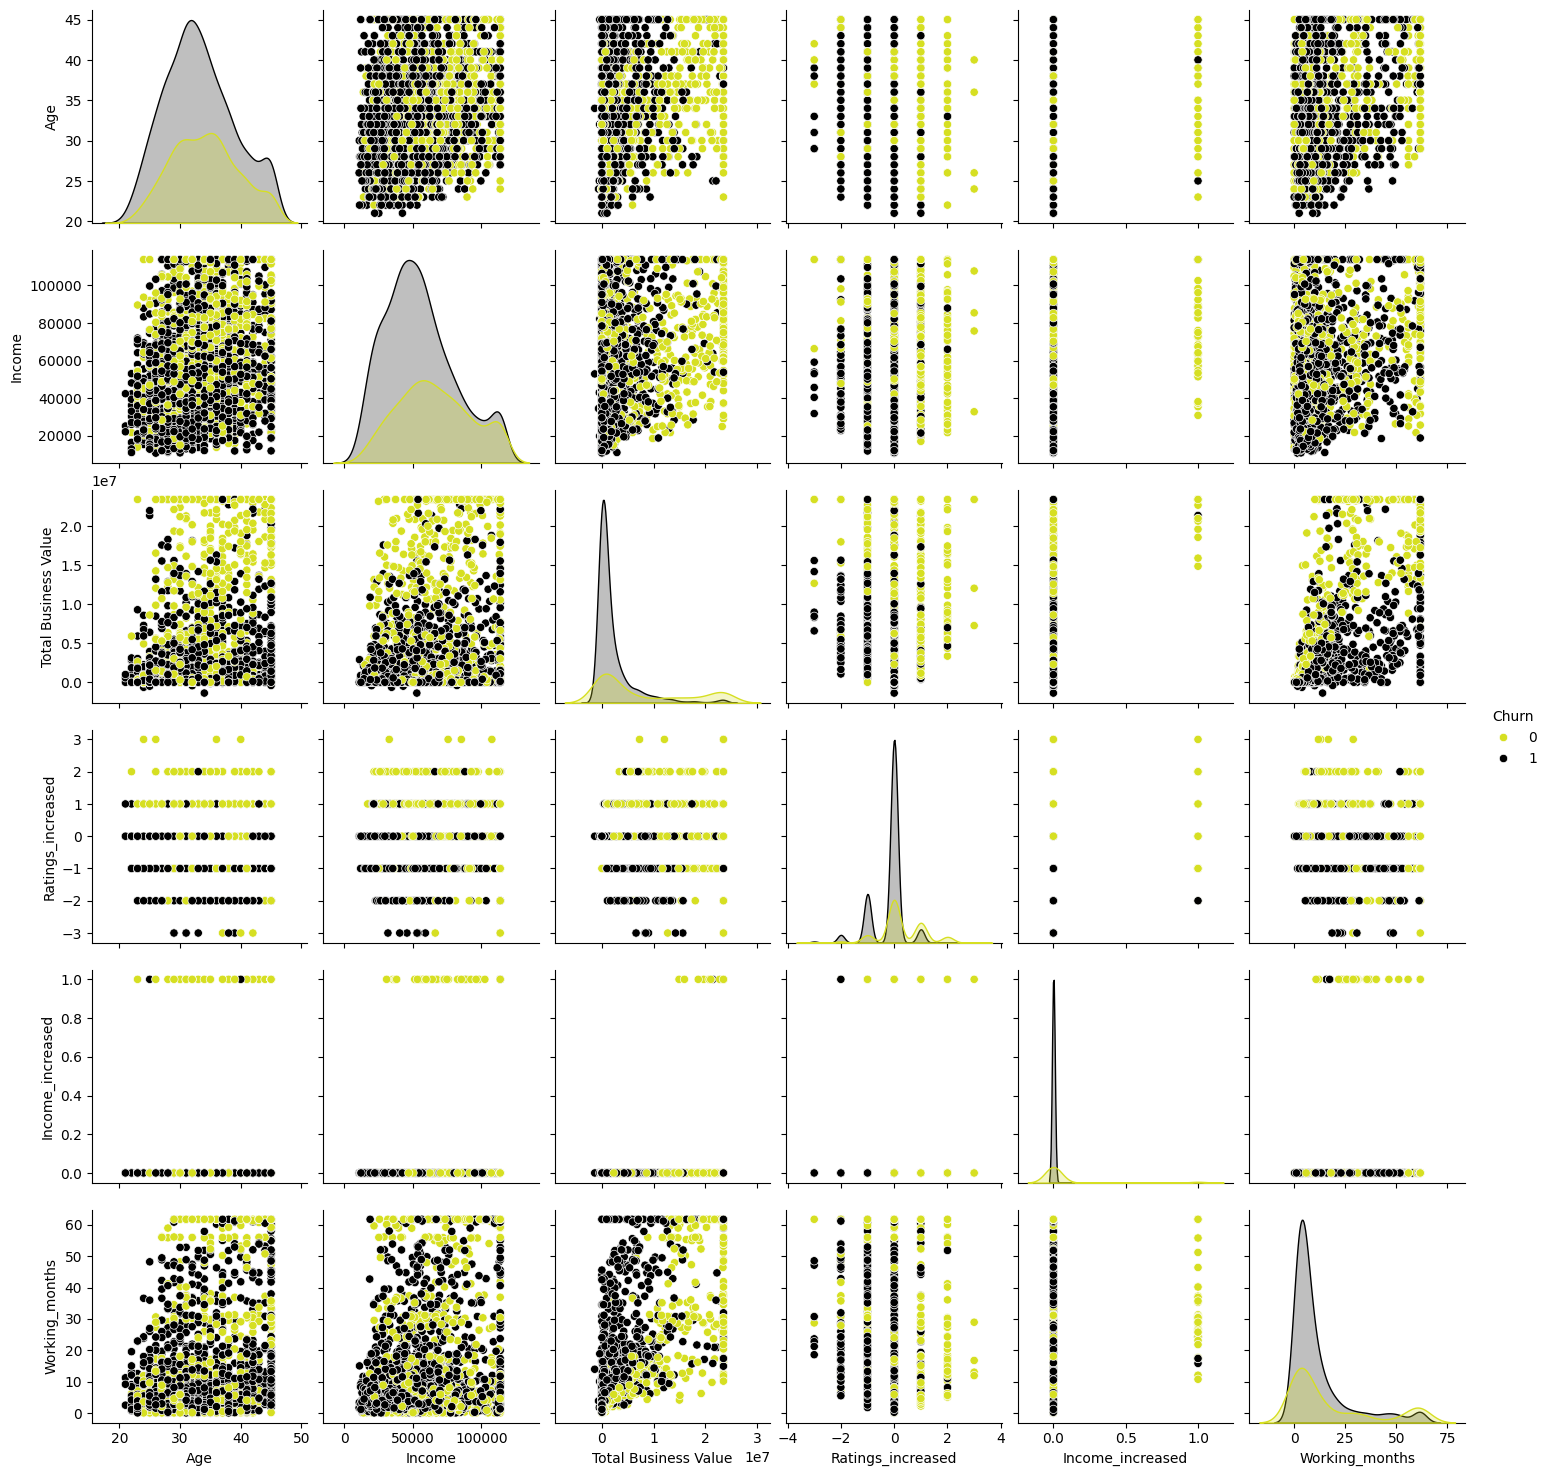

In [370]:
columns=df_agg.columns.drop(['Driver_ID','LastWorkingDate'])
plt.figure(figsize=(14,15))
sns.pairplot(df_agg[columns],hue='Churn',palette=cmap_custom(np.linspace(0,1,2)))
plt.show()

- As age, income and total business value increased, drivers are likely to stay.
- If income,and total business increased, drivers stays.
- With increasein Working months,if total business increased, results in more retention too.  

## *Preprocessing data for model building*

In [371]:
# Dropping unncessary columns
df_agg.drop(columns=['Dateofjoining','LastWorkingDate','Driver_ID','Last_Reporting_month'],inplace=True)

In [372]:
# checking structure of final data
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   2381 non-null   float64 
 1   Gender                2381 non-null   category
 2   City                  2381 non-null   object  
 3   Education_Level       2381 non-null   category
 4   Income                2381 non-null   int64   
 5   Joining Designation   2381 non-null   category
 6   Grade                 2381 non-null   category
 7   Total Business Value  2381 non-null   int64   
 8   Last Quarter Ratings  2381 non-null   category
 9   Ratings_increased     2381 non-null   int64   
 10  Income_increased      2381 non-null   int64   
 11  Churn                 2381 non-null   int64   
 12  Working_months        2381 non-null   float64 
dtypes: category(5), float64(2), int64(5), object(1)
memory usage: 161.4+ KB


In [373]:
# @title *Encoding Categorical Features*
dff=pd.get_dummies(df_agg,columns=['City'],drop_first=True,dtype='int')

In [374]:
# Separating features and label
X=dff.drop('Churn',axis=1)
y=dff['Churn']

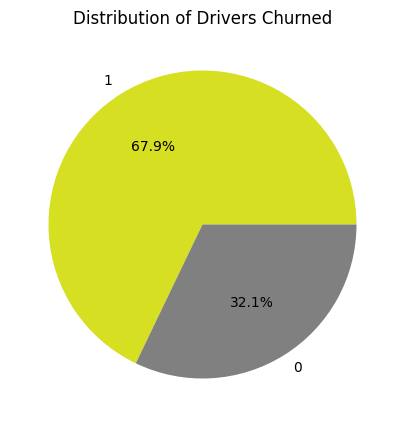

In [375]:
# Checking data balance
y.value_counts().plot(kind='pie',colors=['#D6DF22','grey'],autopct='%1.1f%%')
plt.ylabel('')
plt.title('Distribution of Drivers Churned')
plt.show()

In [376]:
# @title *Balancing and standardising training data*

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
smote=SMOTE()
X_train_bal,y_train_bal=smote.fit_resample(X_train,y_train)

sc=StandardScaler()
X_train_bal_scaled=sc.fit_transform(X_train_bal)
X_test_scaled=sc.transform(X_test)

print('Training dataset size,:',X_train.shape)
print('Testing dataset size,:', X_test.shape)

Training dataset size,: (1904, 39)
Testing dataset size,: (477, 39)


Training dataset size before balancing:, (1904, 39)
Training dataset size after balancing:, (2584, 39)


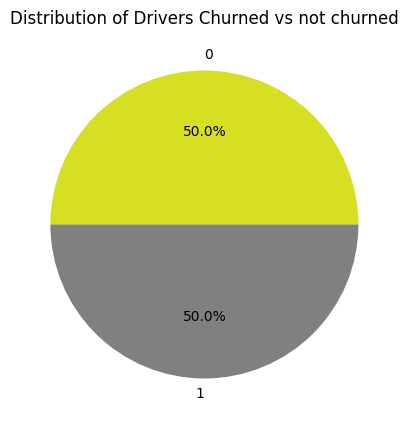

In [377]:
print('Training dataset size before balancing:,',X_train.shape)
print('Training dataset size after balancing:,', X_train_bal.shape)
y_train_bal.value_counts().plot(kind='pie',colors=['#D6DF22','grey'],autopct='%1.1f%%')
plt.ylabel('')
plt.title('Distribution of Drivers Churned vs not churned')
plt.show()

The distribution is balanced now, though Smote doesnt work well with categorial data, Lets try this once<br><br>
# *MODEL BUILDING*


## *RANDOM FOREST CLASSIFIER*

In [378]:
# Before data scaling
params = {
    "max_depth": [3,4,5,6,7,8],
    "min_samples_split": [3,4,5,6,7,8],
    "n_estimators": [50, 100, 150],
    "ccp_alpha":[0.001,0.01,0.1,1]
}

rf = RandomForestClassifier()
gridcv = GridSearchCV(estimator=rf, param_grid=params, n_jobs=-1, cv=5, verbose=4, scoring='f1')
#
gridcv.fit(X_train_bal, y_train_bal)

print("Best Params for Random Forest: ", gridcv.best_params_)
print("Best Score: ", gridcv.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Params for Random Forest:  {'ccp_alpha': 0.001, 'max_depth': 8, 'min_samples_split': 8, 'n_estimators': 150}
Best Score:  0.8632264733055834


In [379]:
# model 1
y_pred = gridcv.best_estimator_.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print("Random Forest Score for training data: ", gridcv.best_score_)
print(f"Random Forest Score for Testing data: {accuracy_rf:.4f}")

print(classification_report(y_test, y_pred))

Random Forest Score for training data:  0.8632264733055834
Random Forest Score for Testing data: 0.8553
              precision    recall  f1-score   support

           0       0.82      0.70      0.76       153
           1       0.87      0.93      0.90       324

    accuracy                           0.86       477
   macro avg       0.85      0.81      0.83       477
weighted avg       0.85      0.86      0.85       477



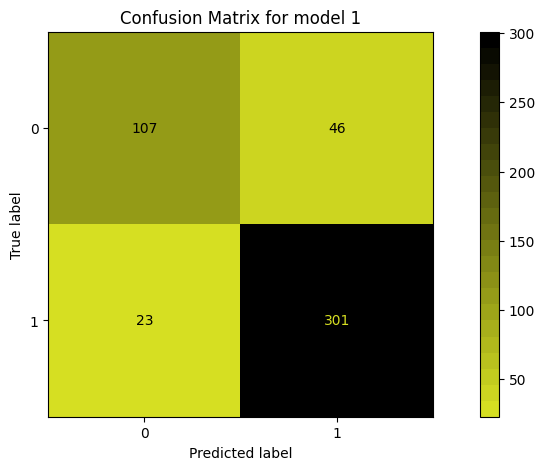

In [380]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gridcv.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 1')
plt.show()

In [381]:
# After Scaling data- model 2

rf2=RandomForestClassifier(ccp_alpha= 0.001, max_depth=  8, min_samples_split= 8, n_estimators= 50,random_state=42)
rf2.fit(X_train_bal_scaled,y_train_bal)
y_pred2=rf2.predict(X_test_scaled)
print('Accuracy Score for training data:',rf2.score(X_train_bal_scaled,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

Accuracy Score for training data: 0.8835139318885449
Accuracy Score for test data: 0.859538784067086
              precision    recall  f1-score   support

           0       0.82      0.72      0.77       153
           1       0.87      0.93      0.90       324

    accuracy                           0.86       477
   macro avg       0.85      0.82      0.83       477
weighted avg       0.86      0.86      0.86       477



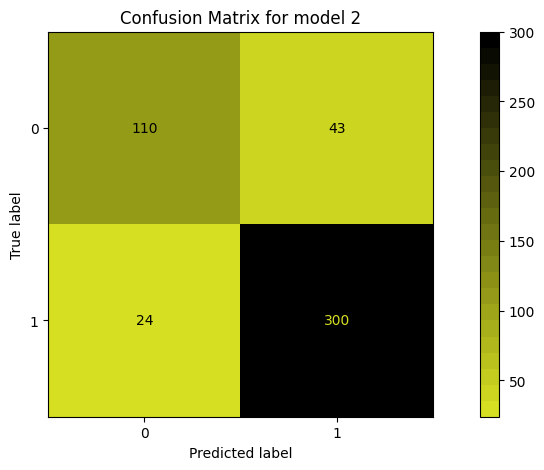

In [382]:
cm = confusion_matrix(y_test, y_pred2)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 2')

plt.show()

In [385]:
# using Class weights to balance data instead of smote - model3

rf3=RandomForestClassifier(ccp_alpha= 0.001, max_depth= 8, min_samples_split =8, n_estimators= 50,random_state=42,class_weight='balanced')
rf3.fit(X_train,y_train)
y_pred3=rf3.predict(X_test)
print('Accuracy Score for training data:',rf3.score(X_train,y_train))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

Accuracy Score for training data: 0.8618697478991597
Accuracy Score for test data: 0.8532494758909853
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       153
           1       0.89      0.89      0.89       324

    accuracy                           0.85       477
   macro avg       0.83      0.83      0.83       477
weighted avg       0.85      0.85      0.85       477



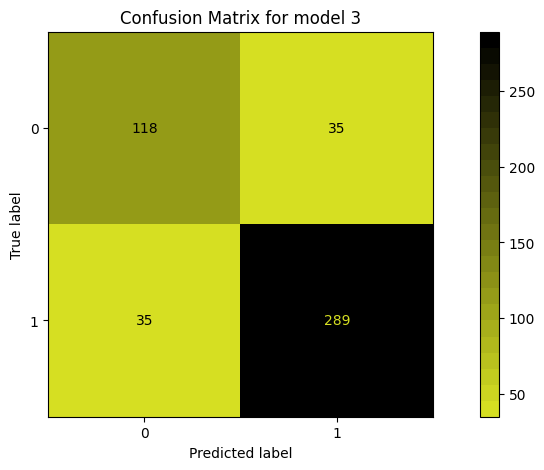

In [386]:
cm = confusion_matrix(y_test, y_pred3)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 3')
plt.show()

As we can see the model result is high with class weights instead of smote. lets go with class weights instead of using smote.
Lets standardise data again without using smote.





In [387]:
# using scaled data with class weights model4
Scale=StandardScaler()
X_train_scaled_1=Scale.fit_transform(X_train)
X_test_scaled_1=Scale.transform(X_test)

rf4=RandomForestClassifier(ccp_alpha= 0.001, max_depth= 8, min_samples_split =8, n_estimators= 50,random_state=42,class_weight='balanced')
rf4.fit(X_train_scaled_1,y_train)
y_pred4= rf4.predict(X_test_scaled_1)
print('Accuracy Score for training data:',rf4.score(X_train_scaled_1,y_train))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

Accuracy Score for training data: 0.8618697478991597
Accuracy Score for test data: 0.8532494758909853
              precision    recall  f1-score   support

           0       0.77      0.77      0.77       153
           1       0.89      0.89      0.89       324

    accuracy                           0.85       477
   macro avg       0.83      0.83      0.83       477
weighted avg       0.85      0.85      0.85       477



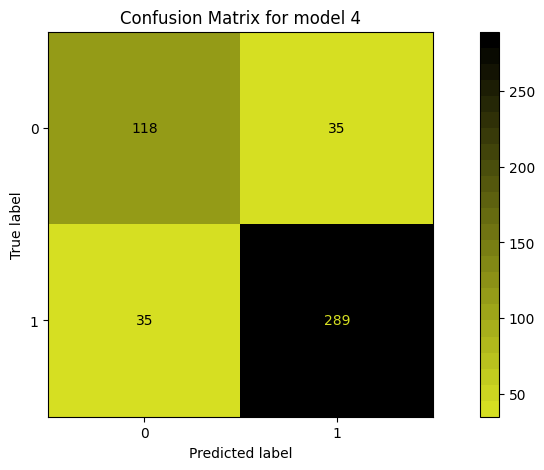

In [388]:
cm = confusion_matrix(y_test, y_pred4)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 4')
plt.show()

Class weights improving the results but it increasing the errors for False Negative which should be the foremost goal to decrease. so lets try with oversampling too.

In [389]:
# model5
ros=RandomOverSampler(random_state=42)
X_train_bal,y_train_bal=ros.fit_resample(X_train,y_train)

scale=StandardScaler()
X_train_bal_scaled_ros=scale.fit_transform(X_train_bal)
X_test_scaled_ros=scale.transform(X_test)

rf5=RandomForestClassifier(ccp_alpha= 0.001, max_depth= 8, min_samples_split =8, n_estimators= 50,random_state=42)
rf5.fit(X_train_bal_scaled_ros,y_train_bal)
y_pred5= rf5.predict(X_test_scaled_ros)

print('Accuracy Score for training data:',rf5.score(X_train_bal_scaled_ros,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred5))
print(classification_report(y_test,y_pred5))

Accuracy Score for training data: 0.8529411764705882
Accuracy Score for test data: 0.8427672955974843
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       153
           1       0.89      0.88      0.88       324

    accuracy                           0.84       477
   macro avg       0.82      0.82      0.82       477
weighted avg       0.84      0.84      0.84       477



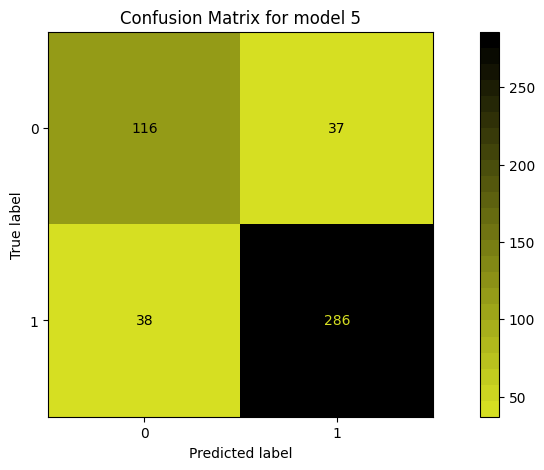

In [390]:
cm = confusion_matrix(y_test, y_pred5)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 5')
plt.show()

So SMOTE is giving the best results, though it may not be balancing the data with categorial datatype.
Lets have a look

In [391]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
smote=SMOTE()
X_train_bal,y_train_bal=smote.fit_resample(X_train,y_train)

sc=StandardScaler()
X_train_bal_scaled=sc.fit_transform(X_train_bal)
X_test_scaled=sc.transform(X_test)

print('Testing dataset size,:', X_test.shape)
print('Training dataset size before balancing:,',X_train.shape)
print('Training dataset size after balancing:,', X_train_bal.shape)

Testing dataset size,: (477, 39)
Training dataset size before balancing:, (1904, 39)
Training dataset size after balancing:, (2584, 39)


In [392]:
smote_data=pd.DataFrame(X_train_bal_scaled)
smote_data.columns=X.columns
smote_data.isna().sum()

,0
Age,0
Gender,295
Education_Level,434
Income,0
Joining Designation,378
Grade,395
Total Business Value,0
Last Quarter Ratings,317
Ratings_increased,0
Income_increased,0


Lets convert features into int using scaling first and then performing SMote to resolve the problem

In [393]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
sc=StandardScaler()
X_train_scaled=sc.fit_transform(X_train)
X_test_scaled=sc.transform(X_test)

smote=SMOTE()
X_train_scaled_bal,y_train_bal=smote.fit_resample(X_train_scaled,y_train)



print('Testing dataset size,:', X_test.shape)
print('Training dataset size before balancing:,',X_train.shape)
print('Training dataset size after balancing:,', X_train_scaled_bal.shape)

Testing dataset size,: (477, 39)
Training dataset size before balancing:, (1904, 39)
Training dataset size after balancing:, (2584, 39)


In [394]:
smote_data=pd.DataFrame(X_train_scaled_bal)
smote_data.columns=X.columns
smote_data.isna().sum().value_counts()

,count
0,39


In [395]:
# model 6
rf6=RandomForestClassifier(ccp_alpha= 0.001, max_depth= 8, min_samples_split =8, n_estimators= 50,random_state=42)
rf6.fit(X_train_scaled_bal,y_train_bal)
y_pred6= rf6.predict(X_test_scaled)
print('Accuracy Score for training data:',rf6.score(X_train_scaled_bal,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

Accuracy Score for training data: 0.8730650154798761
Accuracy Score for test data: 0.8469601677148847
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       153
           1       0.88      0.89      0.89       324

    accuracy                           0.85       477
   macro avg       0.83      0.82      0.82       477
weighted avg       0.85      0.85      0.85       477



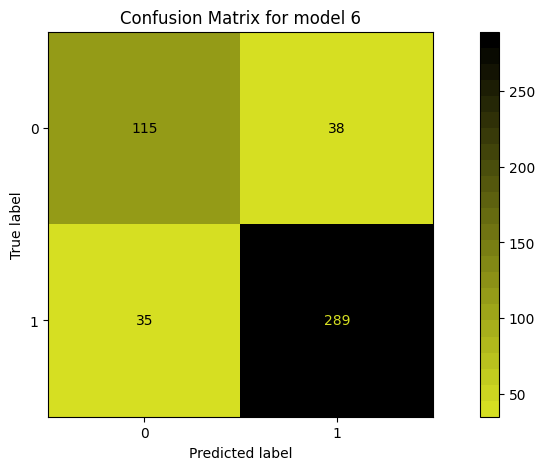

In [396]:
cm = confusion_matrix(y_test, y_pred6)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 6')
plt.show()

Accuracy again dropped showing some problem with cat column smoting.
Lets try to remove irrelevant columns using RFe to improve the score

In [397]:
#model 7
rf7=RandomForestClassifier(ccp_alpha= 0.001, max_depth= 8, min_samples_split =8, n_estimators= 50,random_state=42)
rfe=RFE(estimator=rf7,n_features_to_select=20)
rfe.fit(X_train_scaled_bal,y_train_bal)
rfe.transform(X_test_scaled)
y_pred7=rfe.predict(X_test_scaled)
print('Accuracy Score for training data:',rfe.score(X_train_scaled_bal,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred))

Accuracy Score for training data: 0.8769349845201239
Accuracy Score for test data: 0.8553459119496856


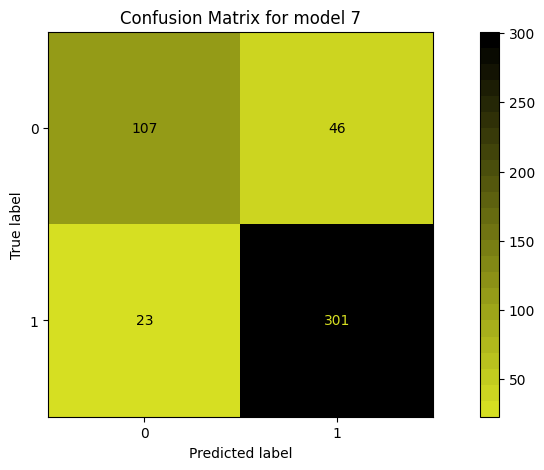

In [398]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 7')
plt.show()

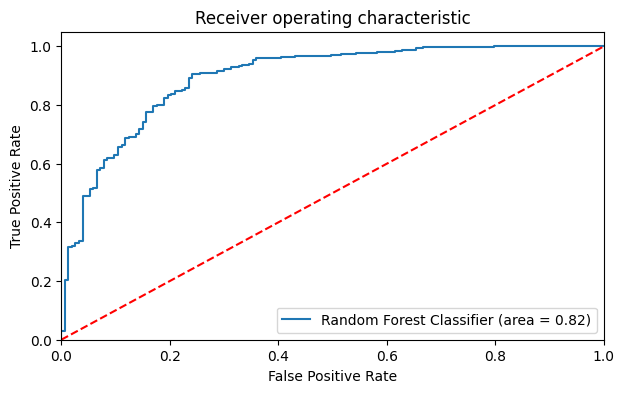

In [399]:
# using ROC-AUC for model 2
logit_roc_auc=roc_auc_score(y_test,y_pred2)
fpr,tpr,thresholds=roc_curve(y_test,rf2.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(7,4))
plt.plot(fpr,tpr,label='Random Forest Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

- Using calss weight we get best test accuracy, i.e. **0.86** but the recall is less there, which is our goal.
- Using smote and then scaling with hyperparameter tuning giving accuracy **0.85** but recall is 0.88 there. So prefering that model named **MODEL 2**<br><br>

## GRADING *BOOSTING CLASSIFIER*

In [401]:
# hyperparameter tuning for training data
params = {
    "max_depth": [2, 3, 4],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [50,100,150,200]
}

gbdt = GradientBoostingClassifier(random_state=42)
gridcv = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=2, param_grid=params,scoring='recall')

gridcv.fit(X_train, y_train)
print("Best Params for GBDT: ", gridcv.best_params_)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best Params for GBDT:  {'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 2, 'n_estimators': 50, 'subsample': 1}


In [403]:
gbc=gridcv.best_estimator_
print("Accuracy Score for GBDT training data: ", gridcv.best_score_)
gbc.fit(X_train,y_train)
y_pred = gbc.predict(X_test)
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

Accuracy Score for GBDT training data:  0.9241569092969298
Accuracy Score for test data: 0.8721174004192872
              precision    recall  f1-score   support

           0       0.85      0.73      0.79       153
           1       0.88      0.94      0.91       324

    accuracy                           0.87       477
   macro avg       0.86      0.84      0.85       477
weighted avg       0.87      0.87      0.87       477



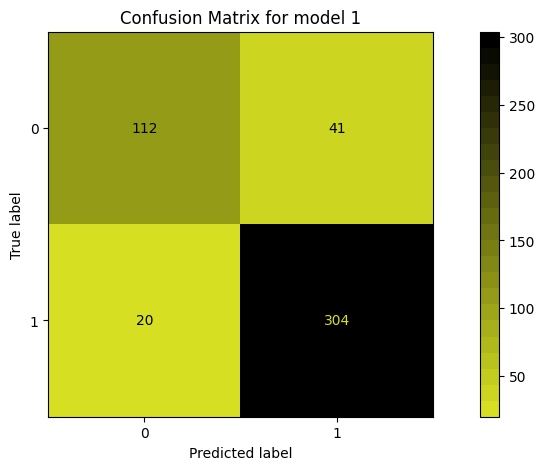

In [404]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gbc.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 1')
plt.show()

In [406]:
scale=StandardScaler()
X_train_scaled=scale.fit_transform(X_train)
X_test_scaled=scale.transform(X_test)

sm=SMOTE(random_state=42)
X_train_scaled_bal,y_train_bal=sm.fit_resample(X_train_scaled,y_train)
# hyperparameter for scaled and smote balanced data
params = {
    "max_depth": [1,2, 3, 4],
    "loss": ["log_loss", "exponential"],
    "subsample": [0.1, 0.2, 0.5, 0.8, 1],
    "learning_rate": [0.1, 0.2, 0.3],
    "n_estimators": [50,100,150,200]
}

gbdt = GradientBoostingClassifier(random_state=42)
gridcv1 = GridSearchCV(estimator=gbdt, cv=3, n_jobs=-1, verbose=2, param_grid=params,scoring='recall')

gridcv1.fit(X_train_scaled_bal, y_train_bal)
print("Best Params for GBDT: ", gridcv1.best_params_)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
Best Params for GBDT:  {'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


In [408]:
gbc1=gridcv1.best_estimator_
print("Accuracy Score for GBDT training data: ", gridcv1.best_score_)
y_pred1 = gbc1.predict(X_test_scaled)
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy Score for GBDT training data:  0.8846436086979982
Accuracy Score for test data: 0.8490566037735849
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       153
           1       0.89      0.89      0.89       324

    accuracy                           0.85       477
   macro avg       0.83      0.83      0.83       477
weighted avg       0.85      0.85      0.85       477



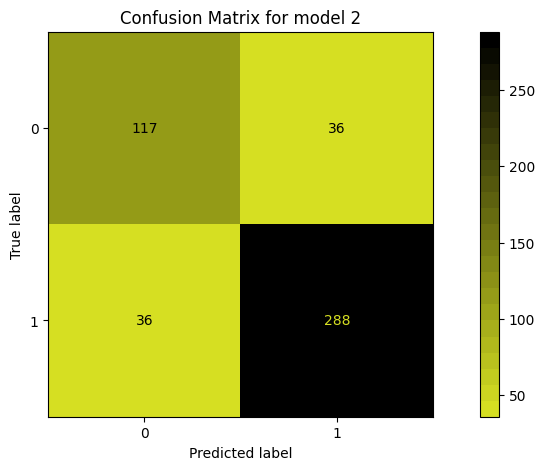

In [409]:
cm=confusion_matrix(y_test,y_pred1)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gridcv1.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for model 2')
plt.show()

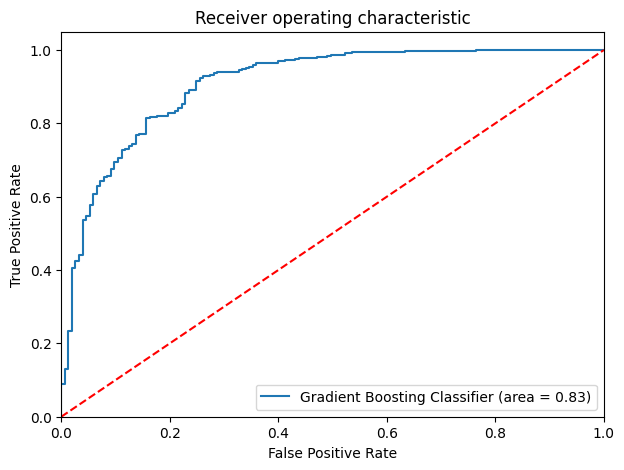

In [410]:
logit_roc_auc=roc_auc_score(y_test,y_pred1)
fpr,tpr,thresholds=roc_curve(y_test,gridcv1.predict_proba(X_test_scaled)[:,1])
plt.figure(figsize=(7,5))
plt.plot(fpr,tpr,label='Gradient Boosting Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## *XGBDT*

In [411]:
from xgboost import XGBClassifier
xgb=XGBClassifier(random_state=42,scoring='recall')
xgb.fit(X_train_scaled_bal,y_train_bal)
y_pred=xgb.predict(X_test_scaled)
print('Accuracy score for training data:',xgb.score(X_train_scaled_bal,y_train_bal))
print('Accuracy Score for testing data:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy score for training data: 0.996517027863777
Accuracy Score for testing data: 0.8532494758909853
              precision    recall  f1-score   support

           0       0.79      0.74      0.76       153
           1       0.88      0.91      0.89       324

    accuracy                           0.85       477
   macro avg       0.84      0.82      0.83       477
weighted avg       0.85      0.85      0.85       477



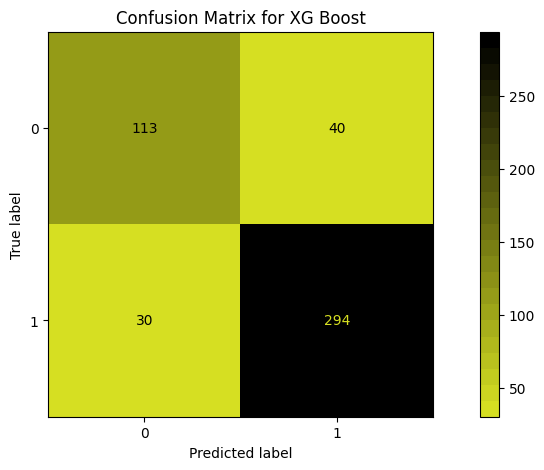

In [412]:
cm=confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for XG Boost')
plt.show()

AS model is overfitting lets do hyperparameter tuning

In [413]:
params = {
        "n_estimators": [50,100,150,200],
        "max_depth" : [3, 4, 5, 7],
        "learning_rate": [0.1, 0.2, 0.3],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        }

xgb=XGBClassifier(random_state=42)
gridcv=GridSearchCV(estimator=xgb,cv=3,n_jobs=-1,verbose=2,param_grid=params,scoring='recall')
gridcv.fit(X_train_scaled_bal,y_train_bal)
print("Best Params for XGB: ", gridcv.best_params_)

xgb = gridcv.best_estimator_
xgb.fit(X_train_scaled_bal,y_train_bal)

print('\n\nModel accuracy for training data:',gridcv.best_score_)
print("Model accuracy for test data:",xgb.score(X_test_scaled, y_test))
y_pred1=xgb.predict(X_test_scaled)
print(classification_report(y_test,y_pred1))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best Params for XGB:  {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}


Model accuracy for training data: 0.8869655929063472
Model accuracy for test data: 0.8574423480083857
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       153
           1       0.89      0.91      0.90       324

    accuracy                           0.86       477
   macro avg       0.84      0.83      0.83       477
weighted avg       0.86      0.86      0.86       477



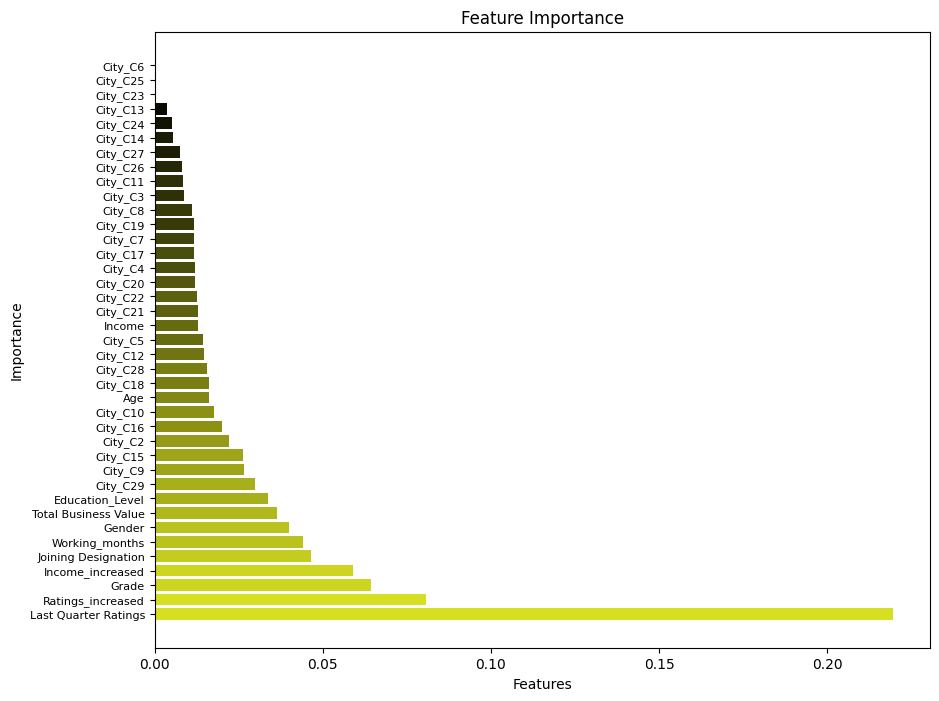

In [414]:
feature_names = X_train.columns
f_imp=xgb.feature_importances_
sorted_idx = np.argsort(f_imp)[::-1]

sorted_feature_names = [feature_names[i] for i in sorted_idx]
sorted_importances = f_imp[sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center',color=cmap_custom(np.linspace(0,1,39)))
plt.yticks(range(len(sorted_importances)), sorted_feature_names,size=8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

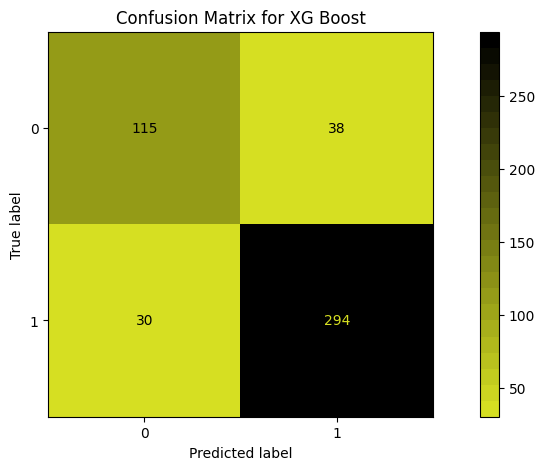

In [415]:
cm=confusion_matrix(y_test,y_pred1)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for XG Boost')
plt.show()

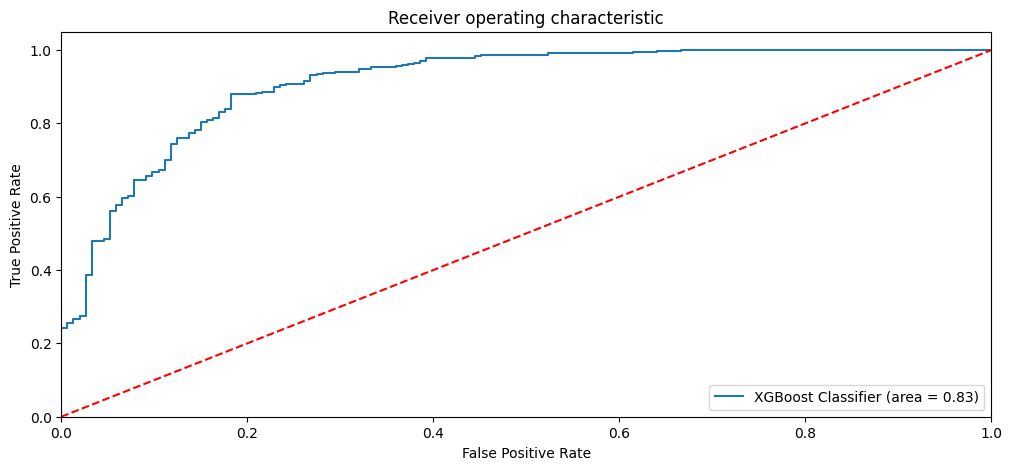

In [416]:
logit_roc_auc=roc_auc_score(y_test,y_pred1)
fpr,tpr,thresholds=roc_curve(y_test,xgb.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## *LIGHT GBM*

In [417]:
lgbm=LGBMClassifier(random_state=42)
lgbm=lgbm.fit(X_train_scaled_bal,y_train_bal)
y_pred=lgbm.predict(X_test_scaled)

print('\n\n\nAccuracy Score for training data:',lgbm.score(X_train_scaled_bal,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[LightGBM] [Info] Number of positive: 1292, number of negative: 1292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 2584, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000



Accuracy Score for training data: 0.9787151702786377
Accuracy Score for test data: 0.8427672955974843
              precision    recall  f1-score   support

           0       0.77      0.72      0.75       153
           1       0.87      0.90      0.89       324

    accuracy                           0.84       477
   macro avg       0.82      0.81      0.82       477
weighted avg       0.84      0.84      0.84       477



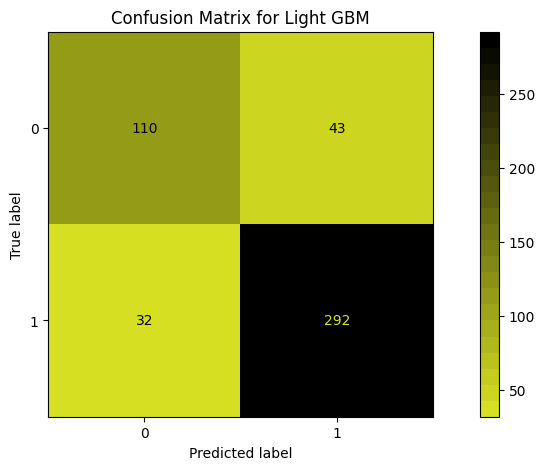

In [418]:
cm=confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgbm.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for Light GBM')
plt.show()

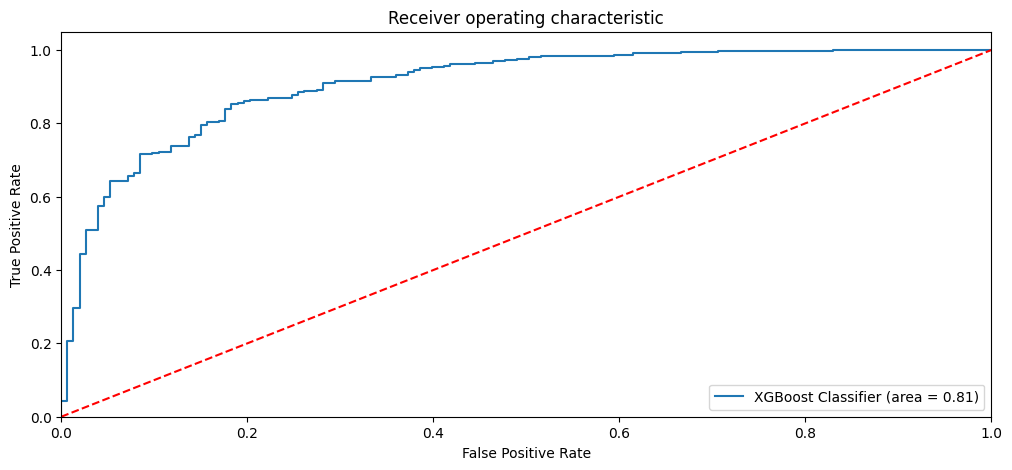

In [419]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,lgbm.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## *ADABOOST*

In [420]:
ada=AdaBoostClassifier(random_state=42)
ada.fit(X_train_scaled_bal,y_train_bal)
y_pred=ada.predict(X_test_scaled)

print('Accuracy Score for training data:',ada.score(X_train_scaled_bal,y_train_bal))
print('Accuracy Score for test data:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

Accuracy Score for training data: 0.8575851393188855
Accuracy Score for test data: 0.8658280922431866
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       153
           1       0.90      0.90      0.90       324

    accuracy                           0.87       477
   macro avg       0.85      0.84      0.85       477
weighted avg       0.87      0.87      0.87       477



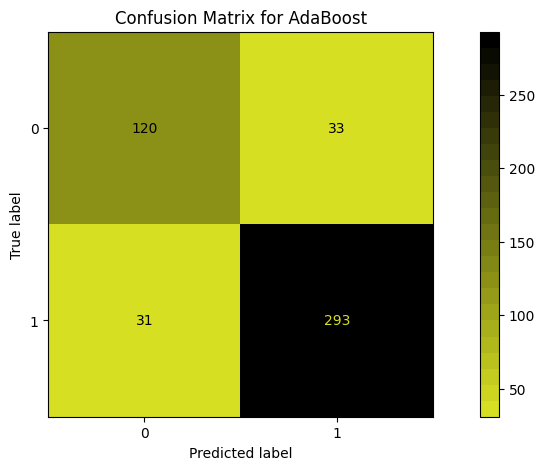

In [421]:
cm=confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ada.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for AdaBoost')
plt.show()

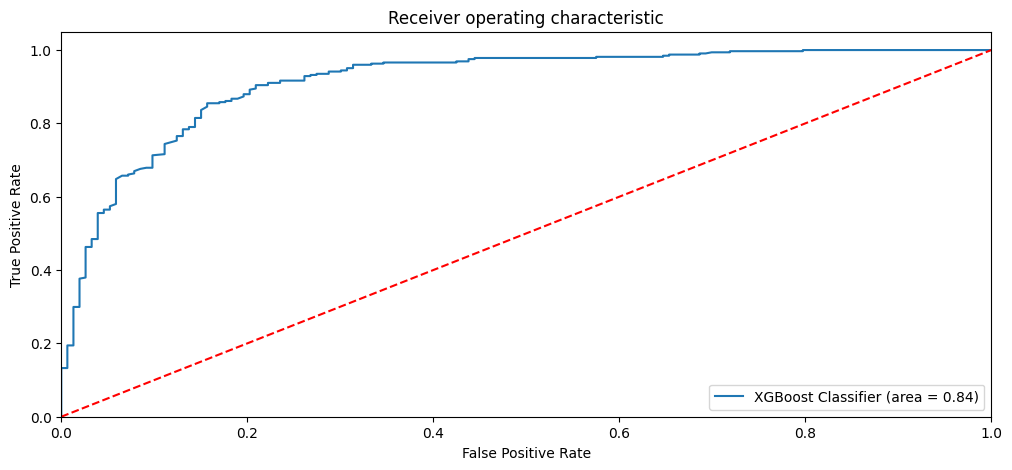

In [422]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,ada.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## *VOTING CLASSIFIER*

In [423]:
vc=VotingClassifier(estimators=[('rf',rf6),('gbc',gbc),('xgb',xgb),('lgbm',lgbm),('ada',ada)],voting='soft')
vc.fit(X_train_scaled_bal,y_train_bal)
vc.predict(X_test_scaled)

print('Accuracy score for training data:',vc.score(X_train_scaled_bal,y_train_bal))
print('Accuracy score for test data:',accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[LightGBM] [Info] Number of positive: 1292, number of negative: 1292
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2177
[LightGBM] [Info] Number of data points in the train set: 2584, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy score for training data: 0.9187306501547987
Accuracy score for test data: 0.8658280922431866
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       153
           1       0.90      0.90      0.90       324

    accuracy                           0.87       477
   macro avg       0.85      0.84      0.85       477
weighted avg       0.87      0.87      0.87       477



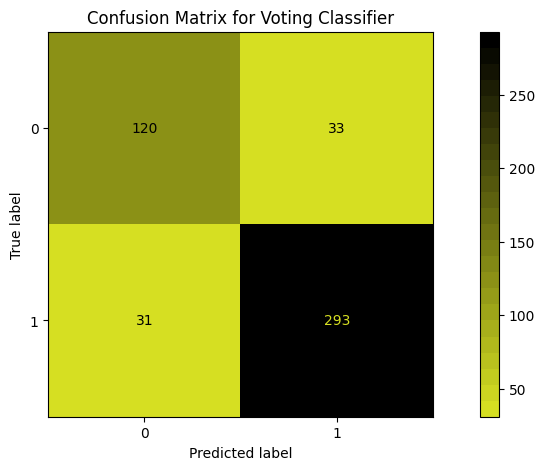

In [424]:
cm=confusion_matrix(y_test,y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=vc.classes_).plot(cmap=cmap_custom)
plt.title('Confusion Matrix for Voting Classifier')
plt.show()

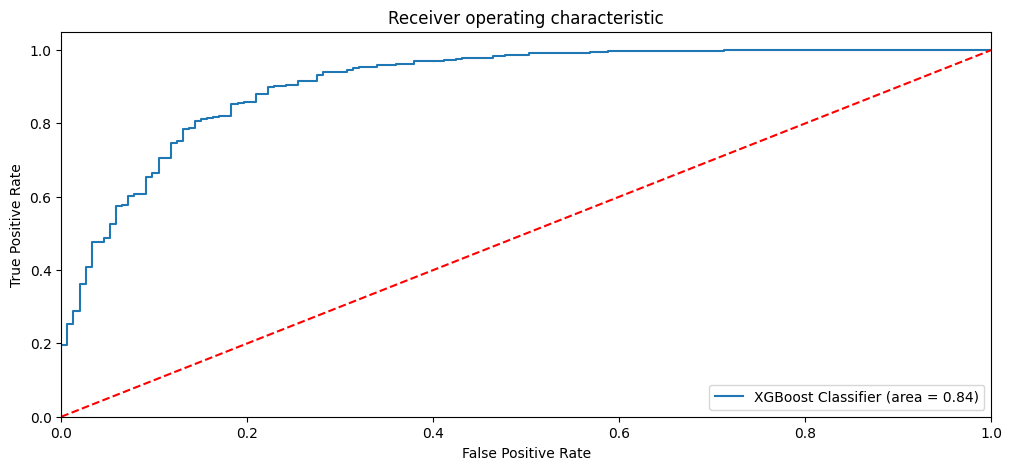

In [425]:
logit_roc_auc=roc_auc_score(y_test,y_pred)
fpr,tpr,thresholds=roc_curve(y_test,vc.predict_proba(X_test_scaled)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='XGBoost Classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# *Summary*

The analysis highlights a high attrition rate (68%) among drivers, indicating substantial turnover, especially among younger, less tenured employees. Key trends include:

1. **Attrition Peaks**: Driver churn is particularly high in early 2019 and mid-2020, with quarter 1 and quarter 4 consistently seeing increased churn rates. July and May show the highest monthly churn, while August and April are lower.

2. **Performance & Tenure**: Drivers with shorter tenures (under a year) show higher attrition rates. A significant correlation exists between low performance ratings and churn, suggesting a link between engagement and performance.

3. **Income Stagnation**: Minimal income growth (less than 2% for most drivers) correlates with high churn, likely driven by salary dissatisfaction.

4. **Demographic Distribution**: While the majority of churned drivers are male, gender and education appear to have little to no effect on churn rates.

5. **Regional Differences**: Cities like C20, C15, and C26 show high churn, possibly due to regional job market conditions or local operational challenges.

The findings suggest churn is driven by factors like limited career growth, income stagnation, and high regional churn disparities.

# *Insights*

1. **High Churn and Business Impact**: With nearly 68% of drivers churning, the business is heavily impacted by the loss of trained and experienced drivers. This churn correlates with lower business value, reduced productivity, and significant retraining costs.

2. **Tenure and Performance Link**: Short-tenured drivers tend to churn at a higher rate. Performance ratings and business value positively correlate with tenure, indicating that longer-serving drivers are more valuable and likely to stay.

3. **Income Stagnation as a Churn Factor**: Since most drivers haven't received income increases, dissatisfaction with compensation may be a driving factor for churn, especially among high-performing drivers who might leave for better-paying opportunities.

4. **City-Specific Churn Patterns**: Some cities, such as C20, C15, and C26, exhibit significantly higher churn, suggesting potential operational or satisfaction issues. Conversely, cities like C5, C19, and C29 have more balanced churn, implying favorable conditions or better alignment with driver needs.

5. **Performance Ratings and Retention**: Drivers with higher performance ratings tend to stay longer, while those with lower ratings are more likely to churn. This may highlight a need for improved engagement or upskilling efforts for low-rated drivers.
 - Ratings may be having some impact socially or financially as high rating employees retention rate is higher than others.

6. **Churn Rate Comparisons**: The 68% churn rate observed here is significantly higher than the typical attrition rate in the gig economy, which generally ranges from 20-50% annually. This elevated rate suggests severe issues with either job satisfaction, career growth, or competitive pay, implying the need for immediate retention strategies.

7. **Income and Cost of Living Correlation**: Higher churn in cities like C20, C15, and C26 might be tied to higher living costs or better job alternatives available in these areas. In major cities, drivers may expect more competitive wages, benefits, and flexibility; thus, inadequate pay or benefits in these high-cost locations can drive attrition.

8. **Joining Date Patterns**: Drivers joining from 2018 onward show higher churn, which may reflect changes in the gig economy post-2017, including intensified competition from similar companies, increased regulatory scrutiny, and shifts in driver expectations around job flexibility and compensation.

9. **Younger Workforce Expectations**: Younger drivers are more likely to churn, aligning with broader trends where younger employees seek career advancement, flexibility, and fair compensation. They are also more likely to switch jobs for even minor improvements in work-life balance or pay.

10. **Attrition and Job Satisfaction in Gig Roles**: In gig work, research shows that lack of benefits, inconsistent income, and limited growth opportunities often contribute to high churn. Since most drivers have low to stagnant income and minimal performance-based incentives, creating a path for rewards or upskilling could mitigate these effects.

These insights indicate that addressing tenure, income growth, and city-specific issues could improve retention rates.

# *Actionable Recommendations*


1. **Increase Pay in High-Churn Cities**: For cities like C20 and C15, consider
locality-based compensation to align with the cost of living and driver expectations. Competitive pay here could reduce attrition driven by economic pressures.
2. **Cities based Analysis**: For cities with high attrition, conducting qualitative analysis (like driver feedback) could reveal actionable insights, such as adjusting incentives, revising working conditions, or addressing specific city-based challenges to improve retention.
3. **Incentivize Tenure**: Introduce monthly bonuses or benefits that increase with tenure, encouraging drivers to stay longer. An annual pay increase, or even incremental raises every six months, could motivate drivers to commit longer-term.
4. **Flexible Scheduling**: Implement flexible shift planning or more control over work hours, as younger employees prioritize flexibility.
5. **Career Pathway Programs**: Develop basic skill-building or certification programs, enhancing long-term job satisfaction and loyalty among younger drivers. Programs might include safe-driving certifications, business skills, or financial literacy workshops.
6. **Introduce Health & Wellness Benefits**: With high competition in the gig economy, providing drivers with basic health insurance, wellness perks (like gym memberships), or mental health support can set the company apart from competitors. Highlighting these benefits during recruitment can attract and retain drivers seeking stability.
7. **Offer Performance-Based Incentives**: Implement a tiered incentive structure based on performance metrics like customer ratings, safe-driving records, and consistent availability. This directly motivates high-performing drivers and may prevent them from switching to competitors for similar pay without these added perks.
8. **Establish Feedback Loops**: Introduce a system where drivers can provide regular feedback on operations, safety concerns, and customer interactions. Actively addressing driver feedback, especially from high-churn cities, helps identify local operational issues.
9. **Implement Career Counselling and Support**: Offer periodic one-on-one sessions with managers or mentors to help drivers address any challenges they face. Clear communication can uncover issues like operational inefficiencies or dissatisfaction with schedules, which often push drivers toward competitors.
10. **Implement Peer Recognition Programs**: Recognize top drivers each month with an “Employee of the Month” award or a similar recognition initiative. This fosters a sense of community and shared purpose, increasing job satisfaction and loyalty.
11. **Host Local Engagement Events**: Organize periodic, casual meet-ups or town-hall meetings for drivers to build camaraderie and engage with management. This can improve driver morale and foster a supportive work culture, helping to retain drivers.
12. **Early Churn Prediction Models**: Deploying models to identify at-risk drivers and proactively reaching out to these drivers with tailored retention offers—such as schedule adjustments or small financial incentives—can reduce churn.
13. **Benchmark Against Competitors**: Regularly evaluate competitor offerings to stay aware of industry standards and avoid losing drivers to better benefits, pay structures, or operational efficiency. Use this data to continuously adjust and improve your retention strategies.
14. **Increase Quarterly Ratings**: Employees who experience an increase in their quarterly ratings are less likely to leave the company. Implementing measures to boost quarterly ratings could help in reducing churn.
15. **Reward System for Customer Ratings**: The company should introduce a reward system for customers who provide feedback and rate drivers. This initiative can incentivize customers to participate in the rating process, leading to more comprehensive feedback and improved driver performance.
16. **Identify Reasons for Low Ratings**: Among the 2,381 employees, 1,744 individuals had their last quarterly rating as 1. Identifying the reasons behind this low rating and implementing corrective measures is crucial for employee retention and overall performance improvement.
17. **Intervention for Stagnant Ratings**: It is concerning that the quarterly rating has not increased for 2,076 employees out of 2,381. This signals a need for closer monitoring and intervention to address any underlying issues affecting employee satisfaction and performance.
18. **Predictive Features for Employee Turnover**: Key features such as Last Quarterly Rating, Total Business Value, and Quarterly Rating Increase should be closely tracked as predictors of employee turnover. Analyzing these features can help identify drivers at risk of leaving the company and implement targeted retention strategies.
19. **Gather More Data for Improved Model Performance**: The dataset imbalancing, affecting the recall score for target 0 (employees who stay in the company). Gathering more data can help address this issue and can improve the model's performance in identifying at-risk employees.
20. **Random Forest Classifier Performance**: The Random Forest Classifier achieves a recall score of 91% for employees who left the company. This indicates that the model is effectively identifying individuals at risk of turnover, providing valuable insights for retention efforts.

Each of these initiatives can help mitigate the competition threat while boosting driver satisfaction and company loyalty.
